# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Simulate-data" data-toc-modified-id="Simulate-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulate data</a></div><div class="lev1 toc-item"><a href="#Simulating-$t$-statistic-under-null" data-toc-modified-id="Simulating-$t$-statistic-under-null-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulating $t$ statistic under null</a></div><div class="lev1 toc-item"><a href="#Comparing-log-likelihoods" data-toc-modified-id="Comparing-log-likelihoods-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparing log-likelihoods</a></div><div class="lev2 toc-item"><a href="#With-mean-update" data-toc-modified-id="With-mean-update-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>With mean update</a></div><div class="lev2 toc-item"><a href="#checking-validity-of-test" data-toc-modified-id="checking-validity-of-test-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>checking validity of test</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
    \DeclareMathOperator*{\gp}{\mathcal{GP}}
    \newcommand{\trans}{^{\intercal}}
    \newcommand{\scrS}{\mathscr{S}}
    \newcommand{\sigmaf}{\sigma_{\mathrm{GP}}}
    \newcommand{\sigman}{\sigma_{\epsilon}}
    \newcommand{\sigmatau}{\sigma_{\tau}}
    \newcommand{\sigmabeta}{\sigma_{\beta}}
    \newcommand{\sigmamu}{\sigma_{\mu}}
    \newcommand{\sigmagamma}{\sigma_{\gamma}}
    \newcommand{\svec}{\mathbf{s}}
    \newcommand{\indep}{\perp}
    \newcommand{\iid}{iid}
    \newcommand{\vectreat}{\Ind_{T}}
    \newcommand{\yt}{Y^\mathrm{T}}
    \newcommand{\yc}{Y^\mathrm{C}}
    \newcommand{\boundary}{\partial}
    \newcommand{\sentinels}{\mathbf{\boundary}}
    \newcommand{\eye}{\mathbf{I}}
    \newcommand{\K}{\mathbf{K}}
    \DeclareMathOperator{\trace}{trace}
    \newcommand{\linavg}{\bar{\tau}}
    \newcommand{\invvar}{\tau^{IV}}
$$

Testing against a sharp null hypothesis seems like an obvious thing that people will want to do with spatial regression discontinuity designs. 
To be specific, the sharp null hypothesis would be that the treatment effect along the boundary is zero everywhere: $\tau(\boundary)=0$. 
I call it the sharp null to distinguish it from a hypothesis that the average treatment effect is zero.

So far I've been experimenting with various iterations of chi square tests, the simplest of which is to compute a $\chi^2$ statistic $\mu\trans\Sigma^{-1}\mu$ on the posterior treatment effect at the sentinels, and compare it to a $\chi^2$ distribution. 
But numerical instabilities make it difficult to work out how many degrees of freedom this distribution should have.
I've tried various alternatives and algorithms, which all make some kind of sense, but contradict each other, and suffer from numerical issues.

In this notebook, I implement two tests that rely on parametric bootstraps to derive a null distribution rather than obtaining a theoretical null distribution. 
The first uses the $\chi^2$ statistic above. To be explicit, here's the full procedure:
1. fit $\gp$s to the treatment and control regions
2. optimize their (shared) hyperparameters
2. obtain the “cliff face” posterior means and covariance $\mu$ and $\Sigma$ at the sentinels following our 2$\gp$ procedure
3. compute the observed $\chi^2$ statistic $\chi^2_\mathrm{obs}=\mu\trans\Sigma^{-1}\mu$
3. create a null $\gp$, which is a single $\gp$ covering both regions, with the same hyperparameters
4. simulate from this null $\gp$, and for each simulation
    * fit the two $\gp$s on the simulated data
    * obtain and save the $\chi^2$ statistic
5. compare the distribution of the simulated $\chi^2$ statistics to $\chi^2_\mathrm{obs}$
6. a p-value is obtained as the proportion of simulated values above the observed value
In this notebook, I apply this method to simulated data, with a fairly strong constant treatment effect, and the test unambiguously detects the treatment effect. Obtaining the $\chi^2$ statistic on 1000 random samples takes 4.5 seconds. None of the samples are above the observed value.

The second procedure I implement is the one suggested by LukeM, that uses the log-likelihood rather than the $\chi^2$ statistic at the boundary. 
This could be described as a parametric bootstrap version of a likelihood ratio test. 
Here's the procedure:
1. fit $\gp$s to the treatment and control regions
2. optimize their (shared) hyperparameters
3. obtain the log-likelihood (sum of the two log-likelihoods)
3. create a null $\gp$, which is a single $\gp$ covering both regions, with the same hyperparameters
4. obtain its log-likelihood
5. compute $\Delta\log P_\mathrm{obs}$, the difference between the $2\gp$ log-likelihood and the null model log-likelihood
4. simulate from the null $\gp$, and for each simulation
    * update the mean parameter of the null and alternative $\gp$s to their respective empirical values
    * fit the two $\gp$s on the simulated data
    * fit the null model to the simulated data
    * obtain the log-likelihoods for the null and alternative model
    * store their difference, $\Delta\log P_\mathrm{sim}$
5. compare the distribution of the simulated $\Delta\log P_\mathrm{sim}$ to $\Delta\log P_\mathrm{obs}$
6. a p-value is obtained as the proportion of simulated values above the observed value

In [1]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [2]:
module GeoRDD
    using GaussianProcesses
    using PDMats
    include("src/cliff_face.jl")
    include("src/point_estimates.jl")
    include("src/boot_mLLtest.jl")
end

GeoRDD

# Simulate data

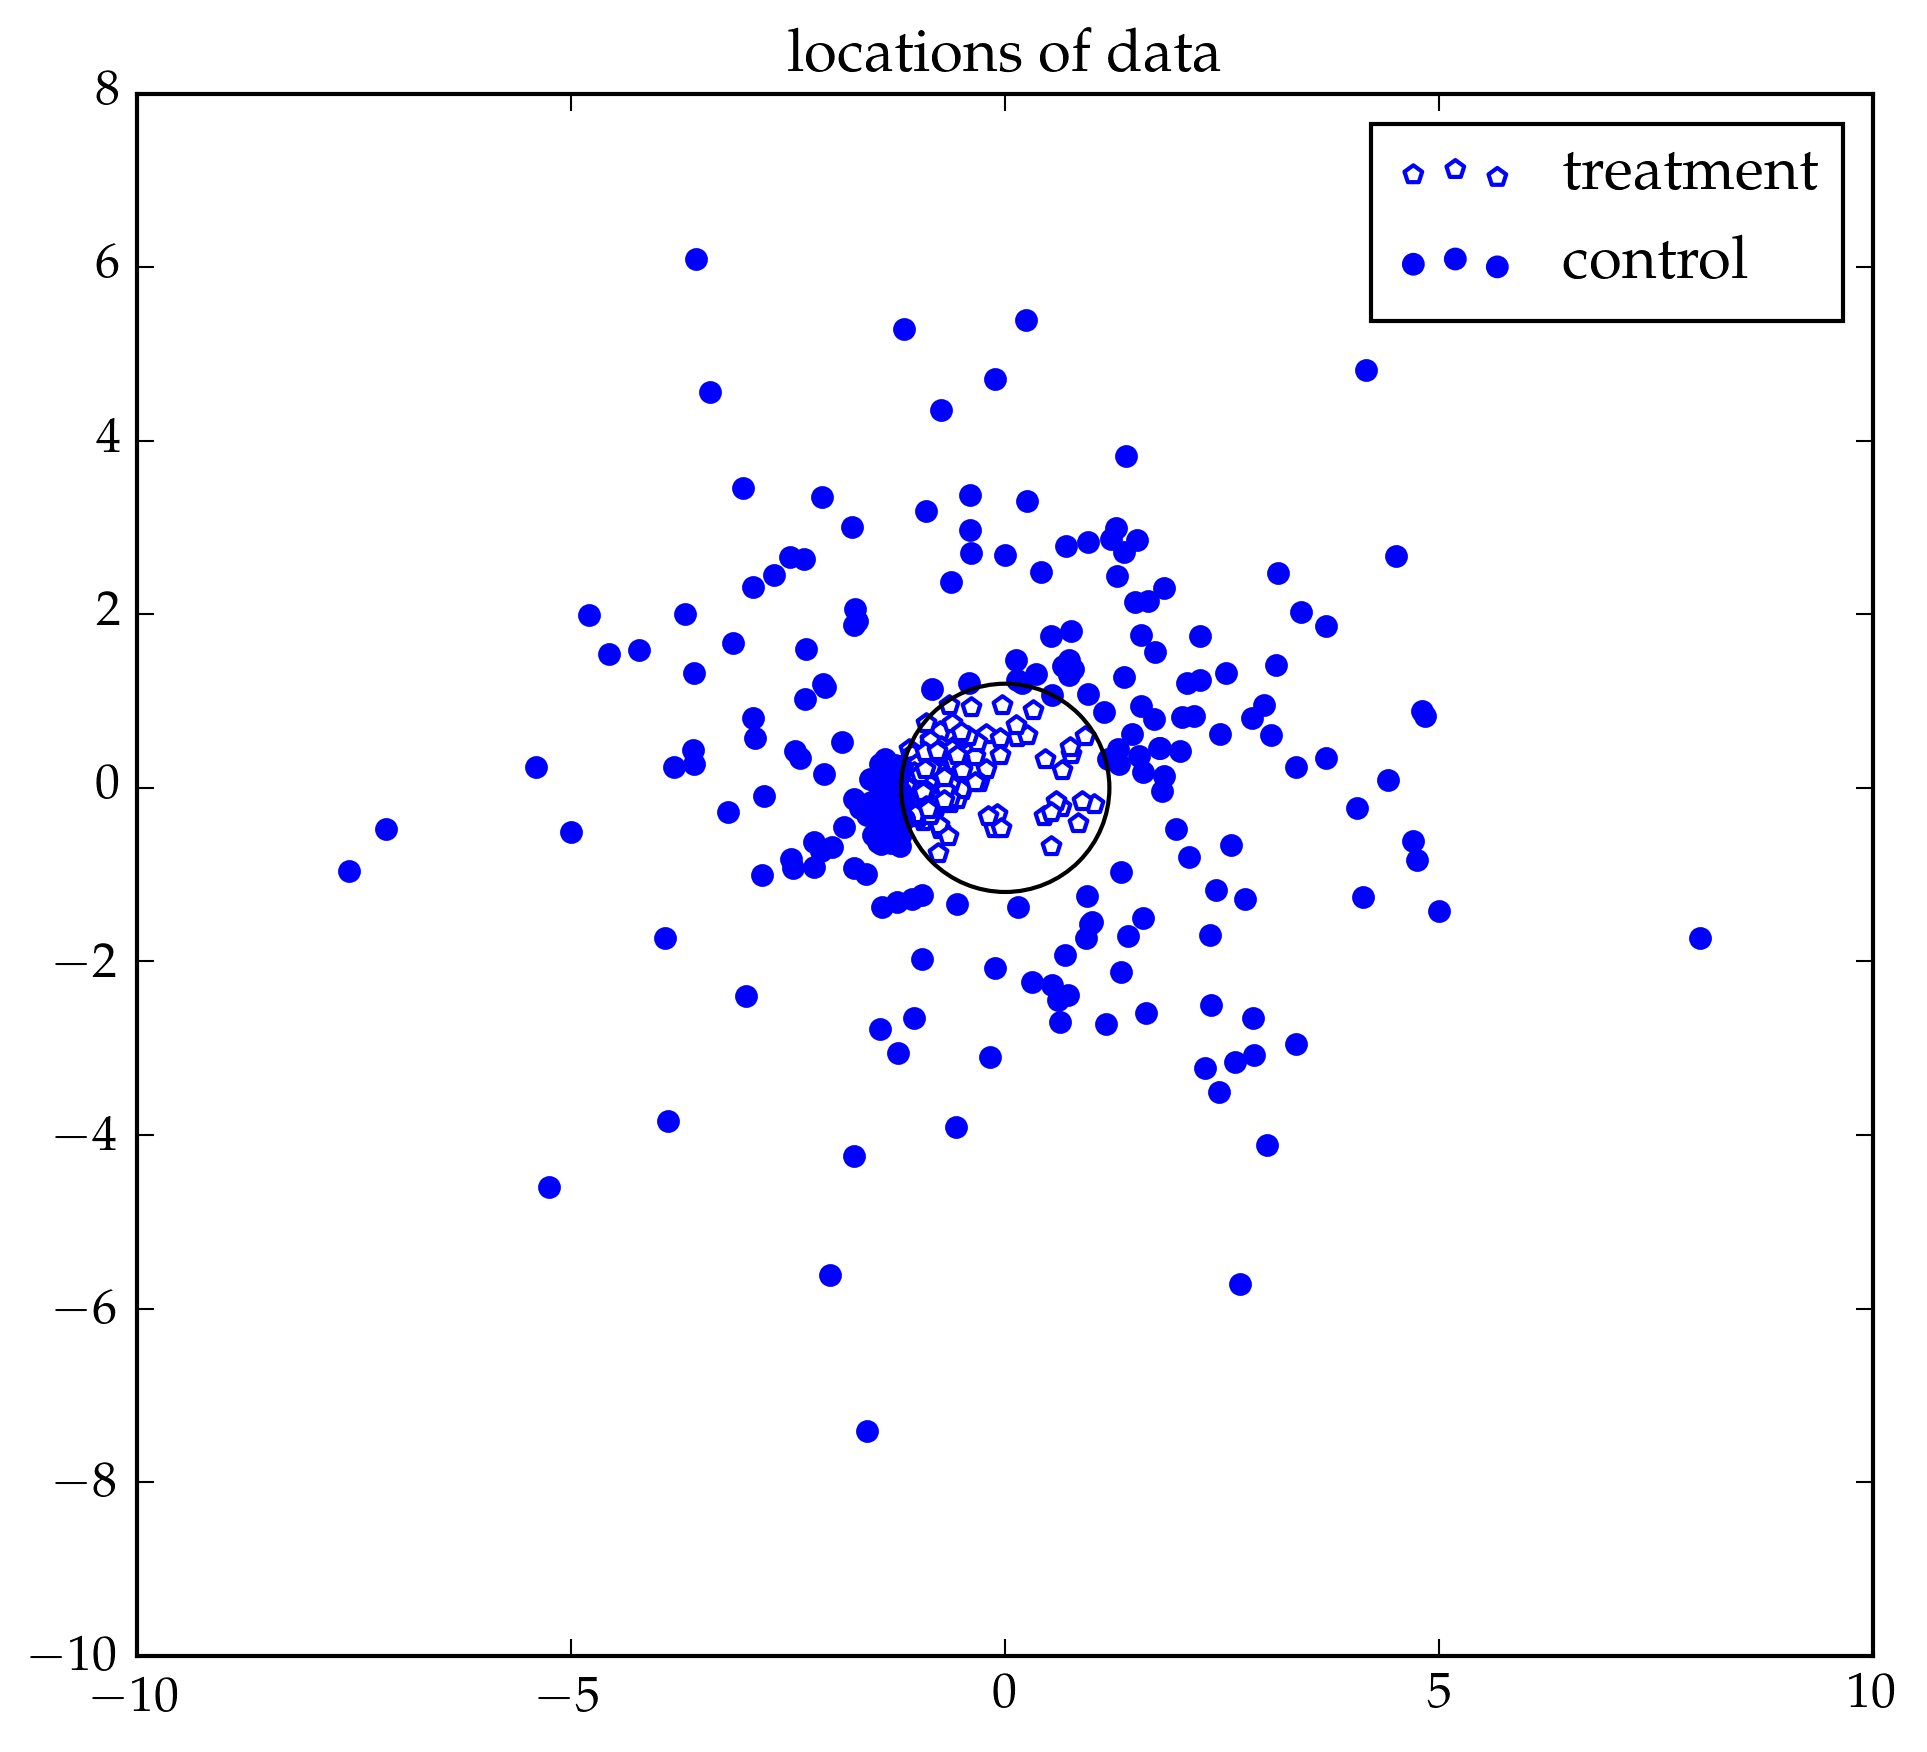

/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [3]:
city = MultivariateNormal([-1.0,0.0], [[0.1,0.05] [0.05, 0.1]])
village = MultivariateNormal([1.0,1.0], [[0.3,-0.1] [-0.1, 0.3]])
countryside = MultivariateNormal([0.0, 0.0], [[5.0,0.0] [0.0, 5.0]])
ncity = 180
nvillage = 10
ncountryside = 200
X=[rand(city, ncity) rand(village, nvillage) rand(countryside, ncountryside)]
_,n = size(X)
r◫ = 1.2
inside = vec((X[1,:].^2 .+ X[2,:].^2) .< r◫^2)
plt.scatter(X[1,inside],X[2,inside], color="white", edgecolor="blue", marker="p", label="treatment")
plt.scatter(X[1,!inside],X[2,!inside], color="blue", label="control")
circle=plt.plt[:Circle]((0,0),r◫,color="black", fill=false)
plt.gca()[:add_artist](circle)
plt.gca()[:set_aspect]("equal")
plt.title("locations of data")
plt.legend(loc="best")
;

In [4]:
Lstar=1.0
σf_star=2.0
σy2_star=0.5
τstar = 1.0 # strong treatment effect
kern = SE(log(Lstar), log(σf_star))

Type: GaussianProcesses.SEIso, Params: [0.0,0.693147]


In [5]:
Σprior=cov(kern, X)
μprior=zeros(n)
Σobs=copy(Σprior)
for i in 1:n
    Σobs[i,i] += σy2_star
end
prior=MultivariateNormal(μprior,Σobs)
Y=rand(prior)
Y[inside] .+= τstar # treatment effect applied inside circle
;

In [6]:
n◫ = 120
α◫ = linspace(0,2π,n◫)
x1◫ = cos(α◫)*r◫
x2◫ = sin(α◫)*r◫
X◫ = [x1◫ x2◫]'
size(X◫)

(2,120)

In [7]:
gp_fit_inside = GP(X[:,inside], Y[inside], MeanZero(), kern, log(√σy2_star))
gp_fit_outside = GP(X[:,!inside], Y[!inside], MeanZero(), kern, log(√σy2_star))
;

In [8]:
μposterior, Σposterior = GeoRDD.cliff_face(gp_fit_outside, gp_fit_inside, X◫)
;

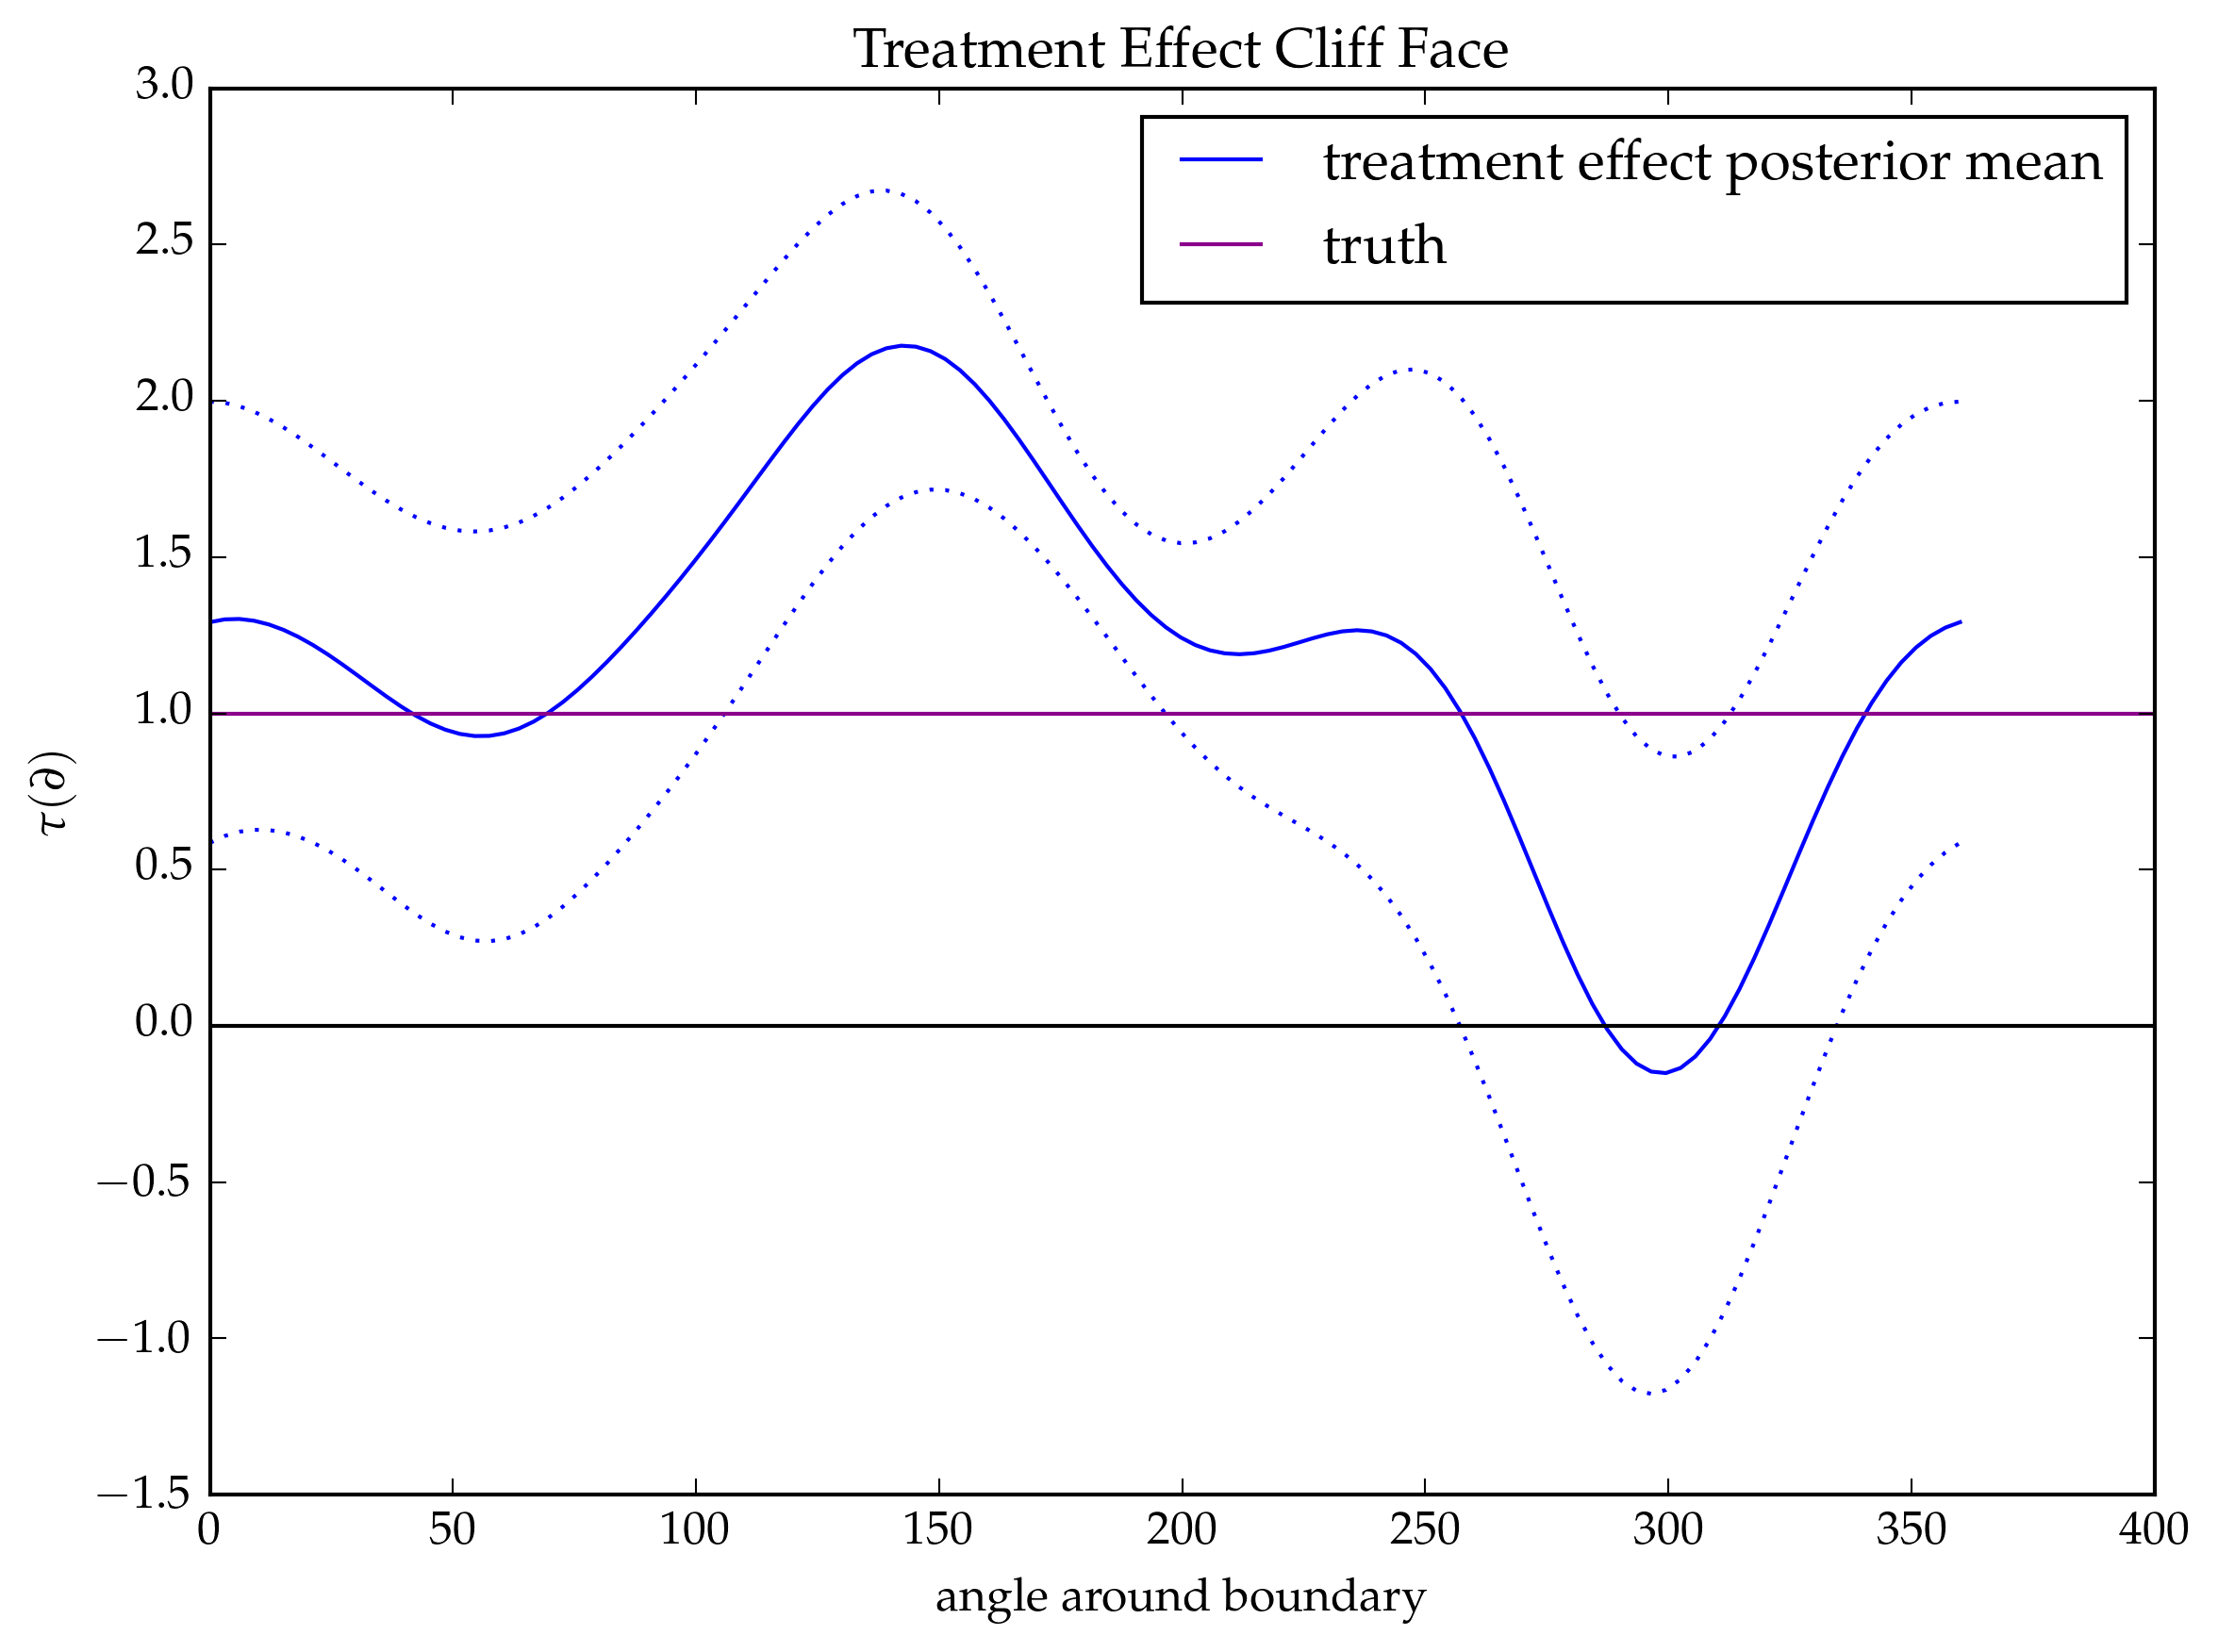

In [9]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(α◫*360/2π, μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(α◫*360/2π, μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(α◫*360/2π, μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black")
plt.axhline(y=τstar, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(\partial)")
plt.xlabel("angle around boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

# Simulating $t$ statistic under null

In [10]:
chi_obsv = GeoRDD.chistat(gp_fit_inside, gp_fit_outside, X◫)

66.28257829172071

In [11]:
@time chi_sims = GeoRDD.nsim_chi(gp_fit_inside, gp_fit_outside, X◫, 1000);

  4.864766 seconds (591.13 k allocations: 2.180 GB, 3.28% gc time)


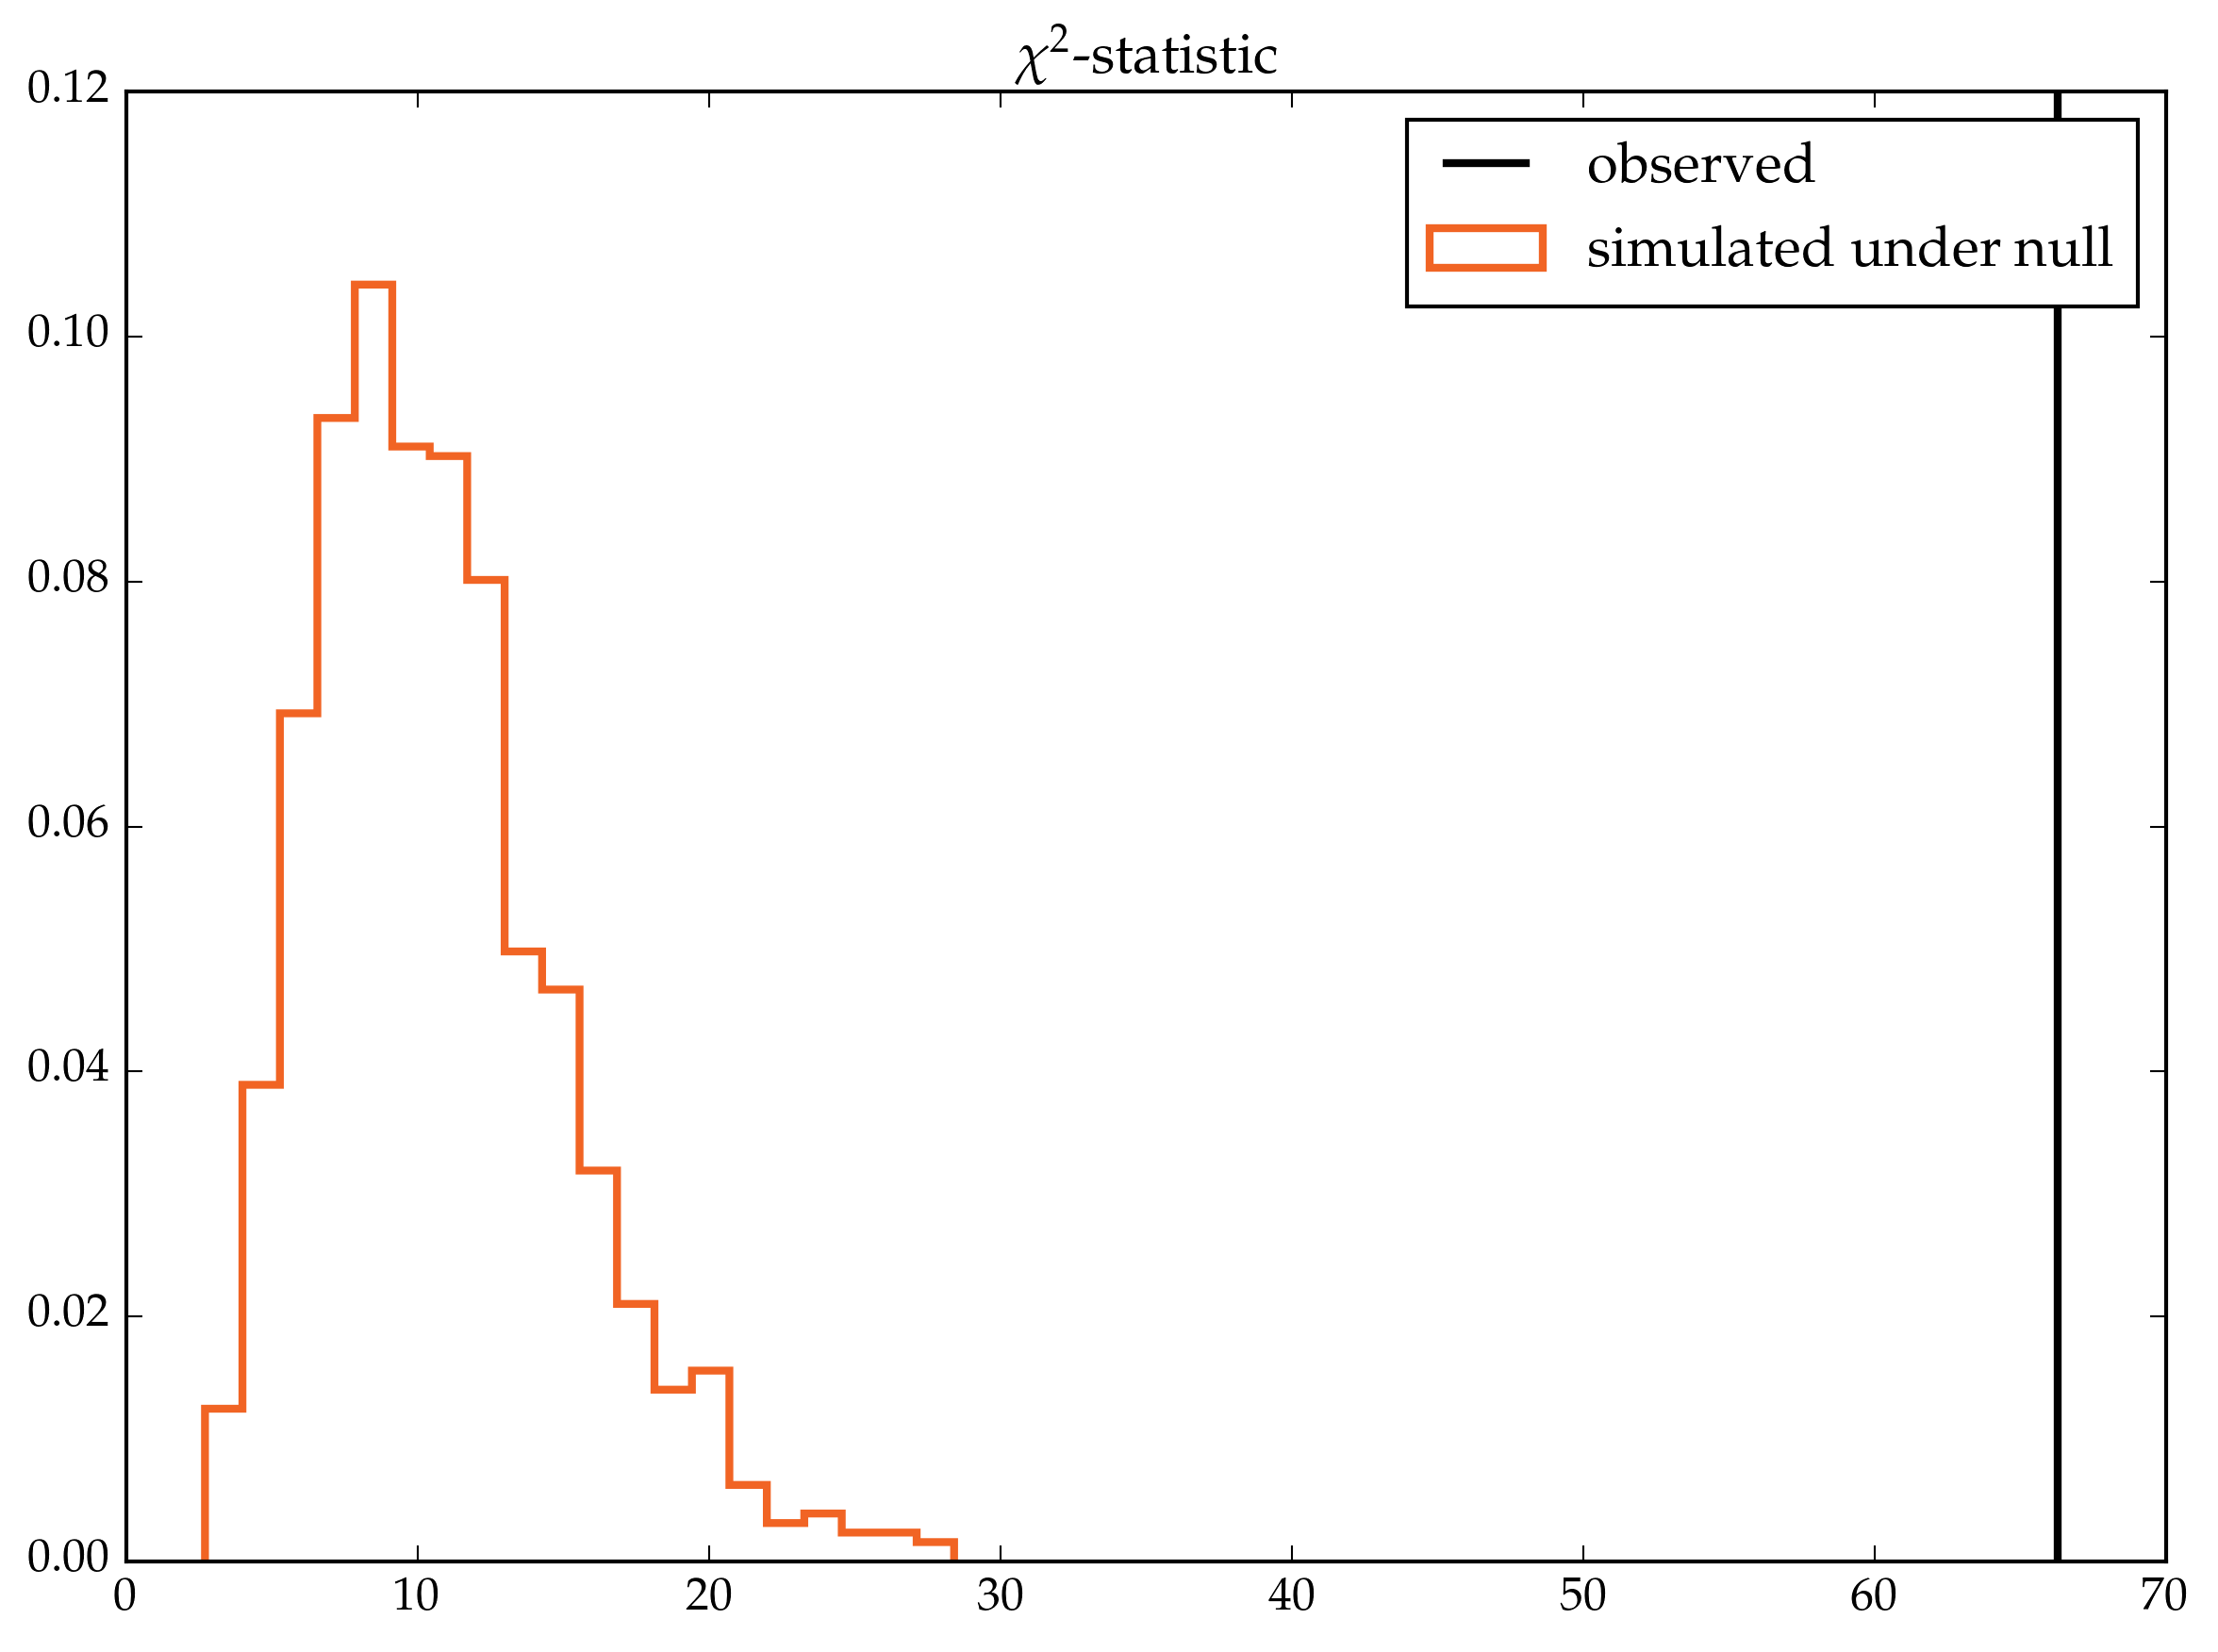

PyObject <matplotlib.text.Text object at 0x31d778090>

In [12]:
plt.plt[:hist](chi_sims, normed=true, bins=20, color="#F16424", histtype="step", linewidth=2, label="simulated under null")
plt.axvline(chi_obsv, color="black", label="observed", linewidth=2)
plt.legend(loc="best")
plt.title(L"$\chi^2$-statistic")

In [13]:
mean(chi_sims .> chi_obsv)

  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/imolk/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/imolk/.julia/v0.5/PyCall/src/PyCall.jl
  li

0.0

# Comparing log-likelihoods

In [14]:
gp_null = GP(X, Y, MeanZero(), kern, log(√σy2_star))

GP object:
  Dim = 2
  Number of observations = 390
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [0.0,0.693147]
  Input observations = 
[-1.30677 -1.29603 … -4.21898 -0.620286; -0.14963 0.0314953 … 1.59301 2.37107]
  Output observations = [-0.277838,0.75189,1.70373,0.0352738,1.69209,0.160768,2.28376,-0.244402,0.366405,1.38292  …  0.918064,2.19911,-0.72922,-0.824488,-0.869789,0.044827,1.6311,1.16265,0.0219135,-0.72831]
  Variance of observation noise = 0.5000000000000001
  Marginal Log-Likelihood = -549.784

In [15]:
mLL_altv = gp_fit_inside.mLL + gp_fit_outside.mLL

-526.2946308087667

In [16]:
prior

FullNormal(
dim: 390
μ: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Σ: [4.5 3.9347 … 0.0126183 0.131822; 3.9347 4.5 … 0.0164952 0.206216; … ; 0.0126183 0.0164952 … 4.5 0.00455422; 0.131822 0.206216 … 0.00455422 4.5]
)


In [17]:
mLL_null = gp_null.mLL

-549.7837251045437

In [18]:
gpT_mod = GeoRDD.modifiable(gp_fit_inside)
gpC_mod = GeoRDD.modifiable(gp_fit_outside)
gpNull_mod = GeoRDD.modifiable(gp_null)
GeoRDD.sim_logP(gpT_mod, gpC_mod, gpNull_mod, inside)
@time mLL_sims = [GeoRDD.sim_logP(gpT_mod, gpC_mod, gpNull_mod, inside) for _ in 1:10000];

  5.774171 seconds (750.47 k allocations: 423.925 MB, 0.72% gc time)


In [19]:
mLL_sim_null = [sim[1] for sim in mLL_sims]
mLL_sim_altv = [sim[2] for sim in mLL_sims]
;

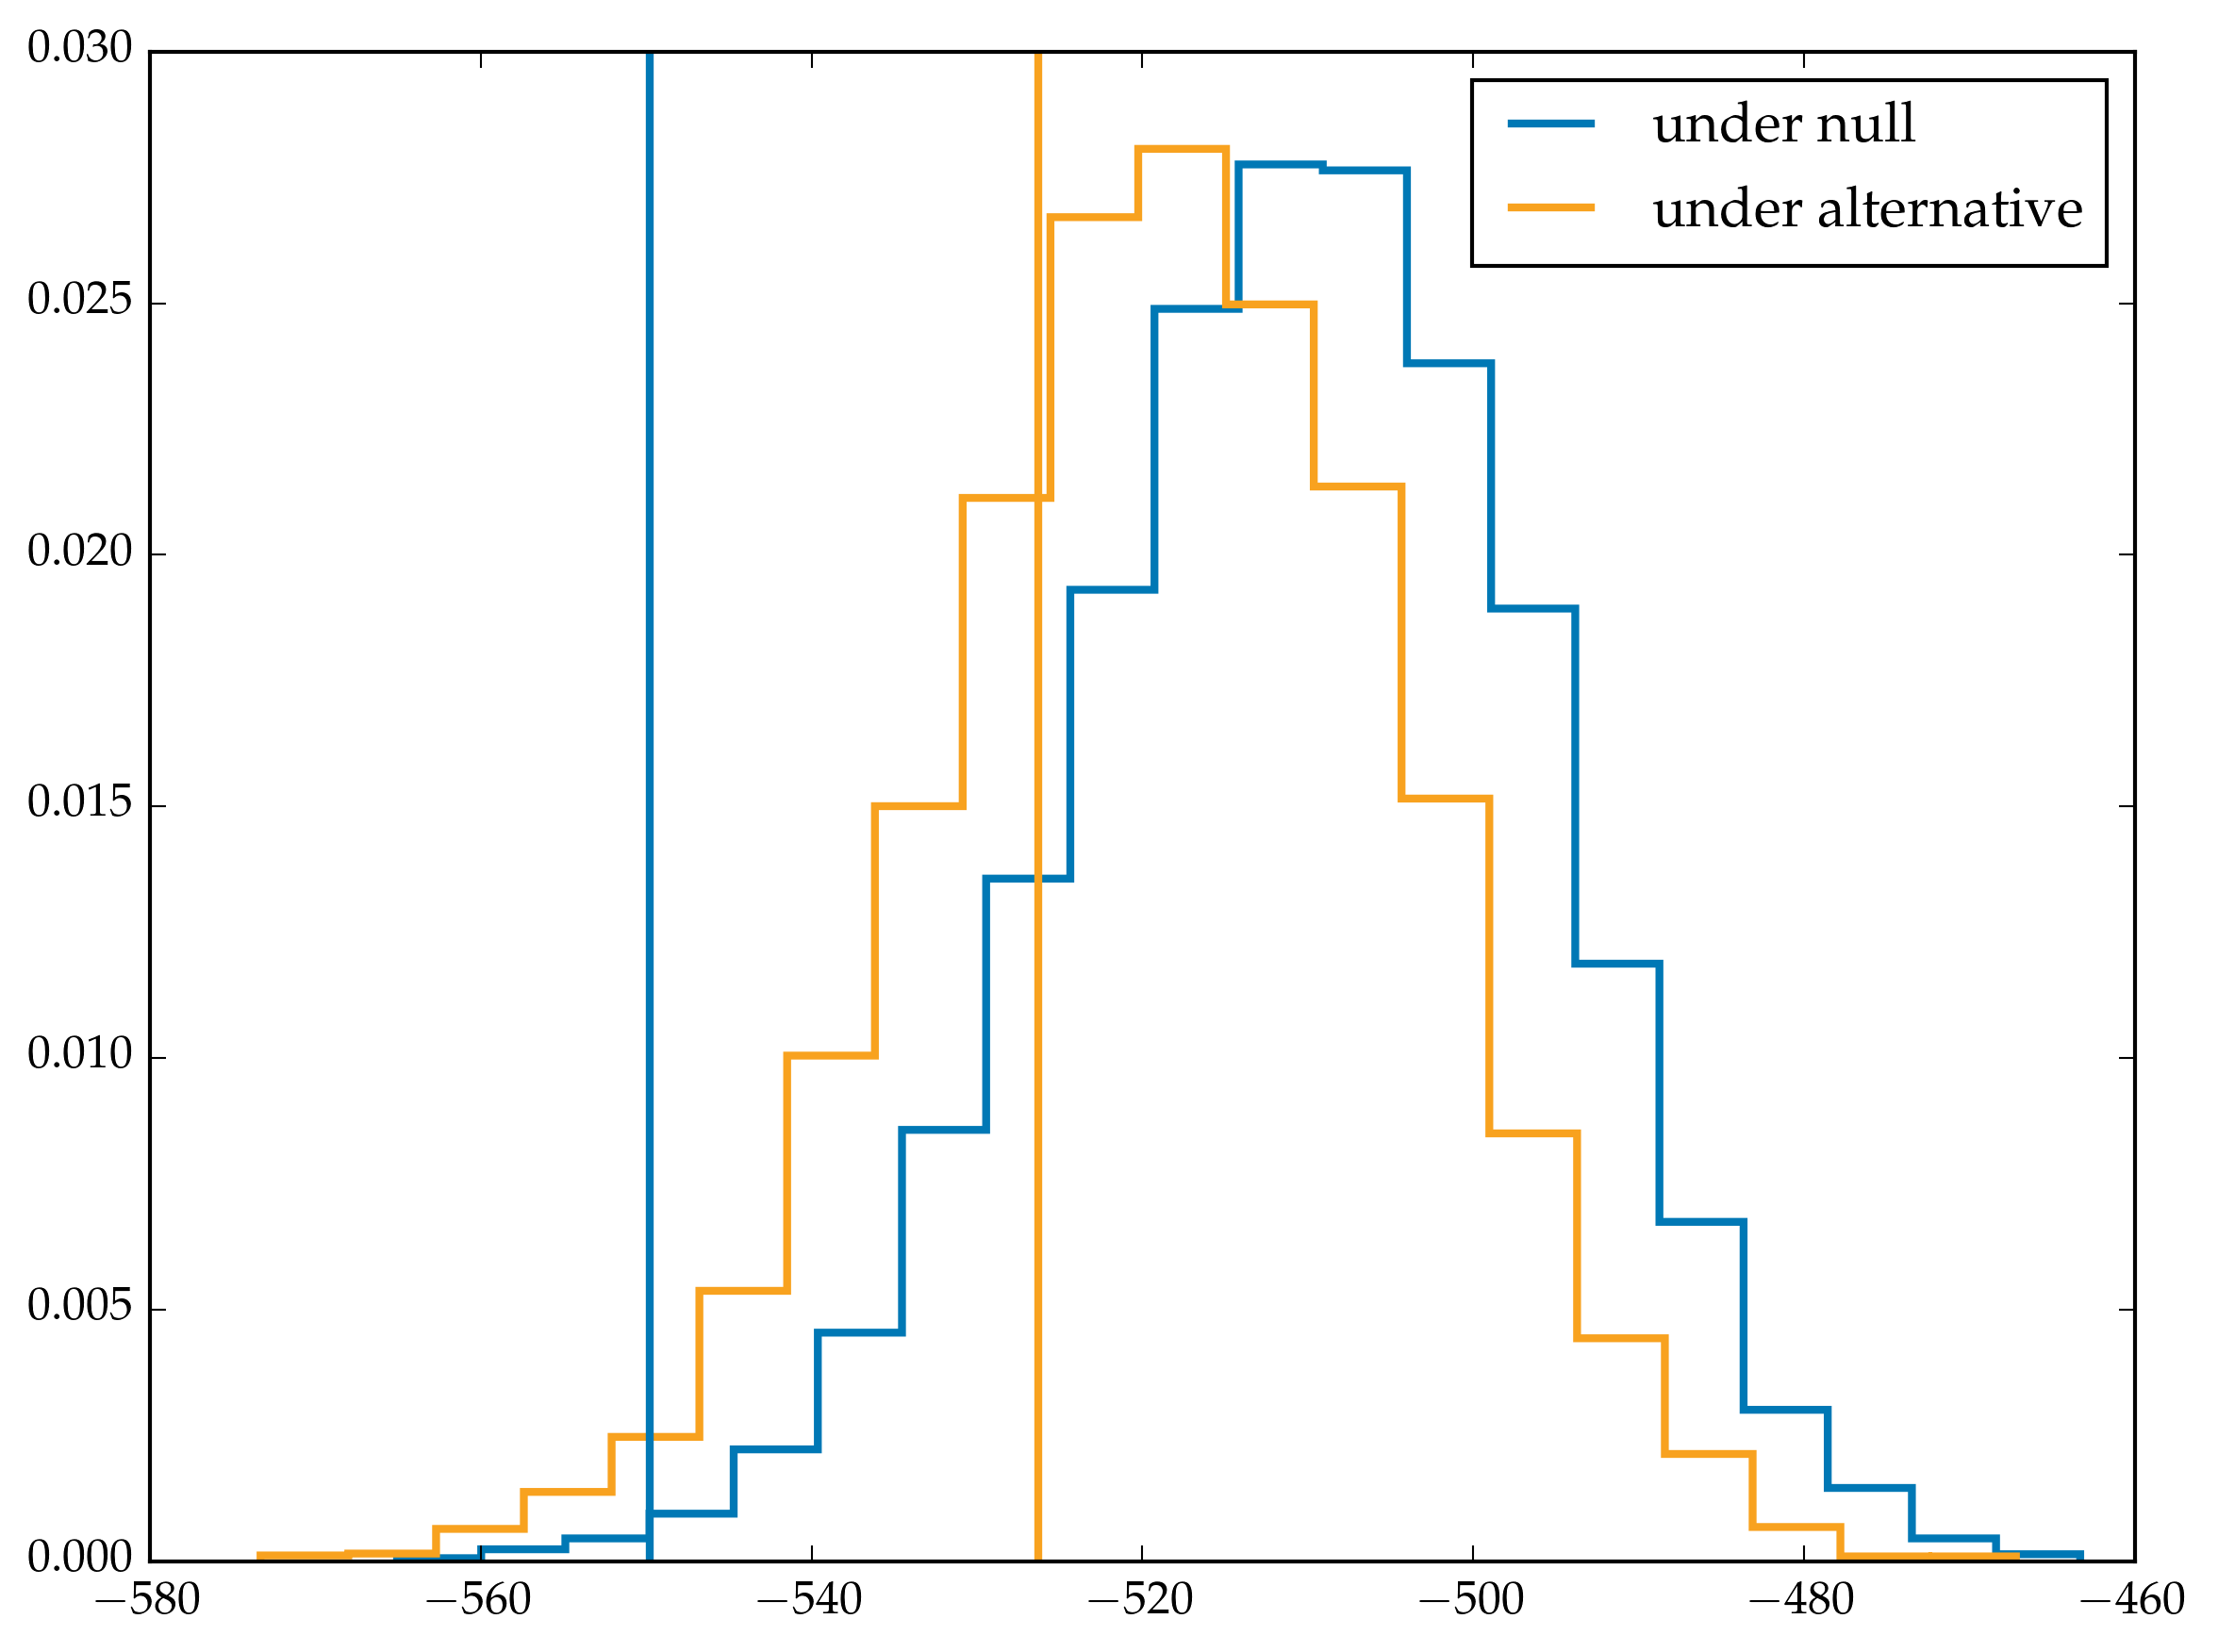

PyObject <matplotlib.legend.Legend object at 0x31a768c50>

In [20]:
plt.plt[:hist](mLL_sim_null, normed=true, bins=20, color="#0078B5", histtype="step", linewidth=2)
plt.plt[:hist](mLL_sim_altv, normed=true, bins=20, color="#F8A21F", histtype="step", linewidth=2)
plt.axvline(mLL_null, color="#0078B5", label="under null", linewidth=2)
plt.axvline(mLL_altv, color="#F8A21F", label="under alternative", linewidth=2)
plt.legend()

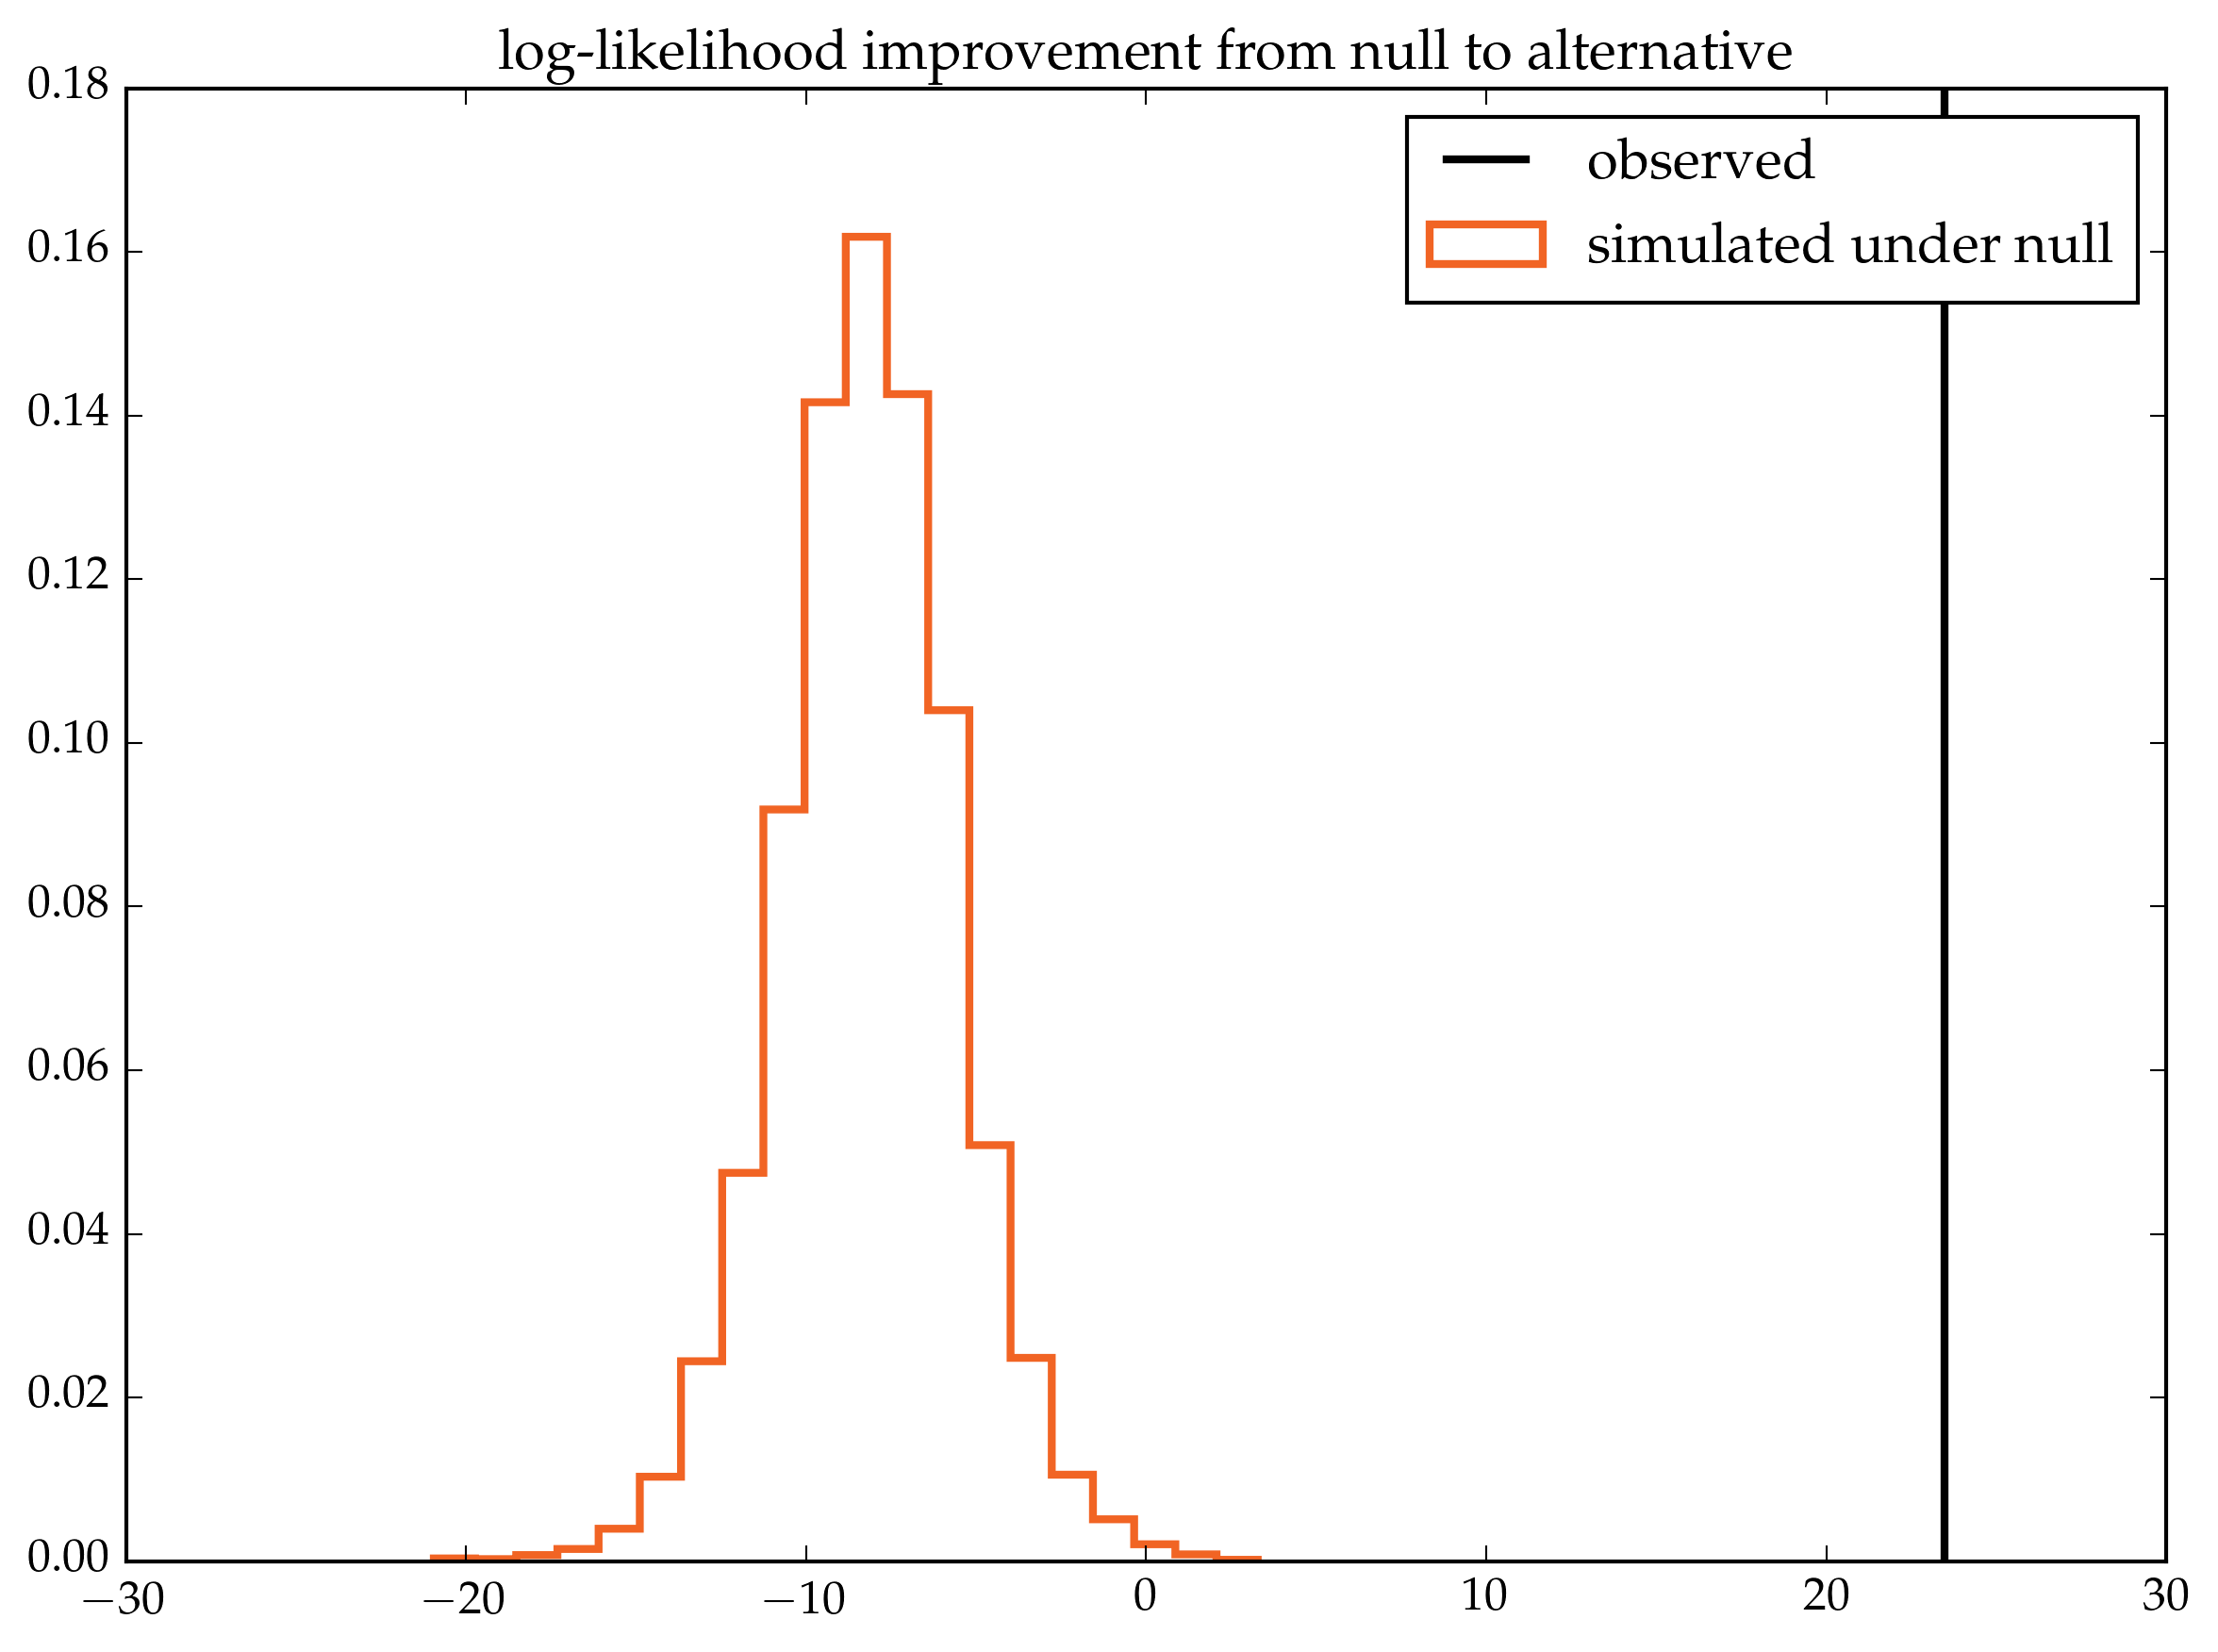

PyObject <matplotlib.text.Text object at 0x31a9eaa90>

In [21]:
plt.plt[:hist](mLL_sim_altv.-mLL_sim_null, normed=true, bins=20, color="#F16424", histtype="step", linewidth=2, label="simulated under null")
plt.axvline(mLL_altv-mLL_null, color="black", label="observed", linewidth=2)
plt.legend(loc="best")
plt.title("log-likelihood improvement from null to alternative")

In [22]:
mean((mLL_sim_altv.-mLL_sim_null) .> (mLL_altv-mLL_null)) # p-value

0.0

## With mean update

In [23]:
@time mLL_sims = GeoRDD.nsim_logP(gp_fit_inside, gp_fit_outside, 10000; update_mean=true);

  6.179127 seconds (798.31 k allocations: 429.263 MB, 0.65% gc time)


In [24]:
mLL_sim_null = [sim[1] for sim in mLL_sims]
mLL_sim_altv = [sim[2] for sim in mLL_sims]
;

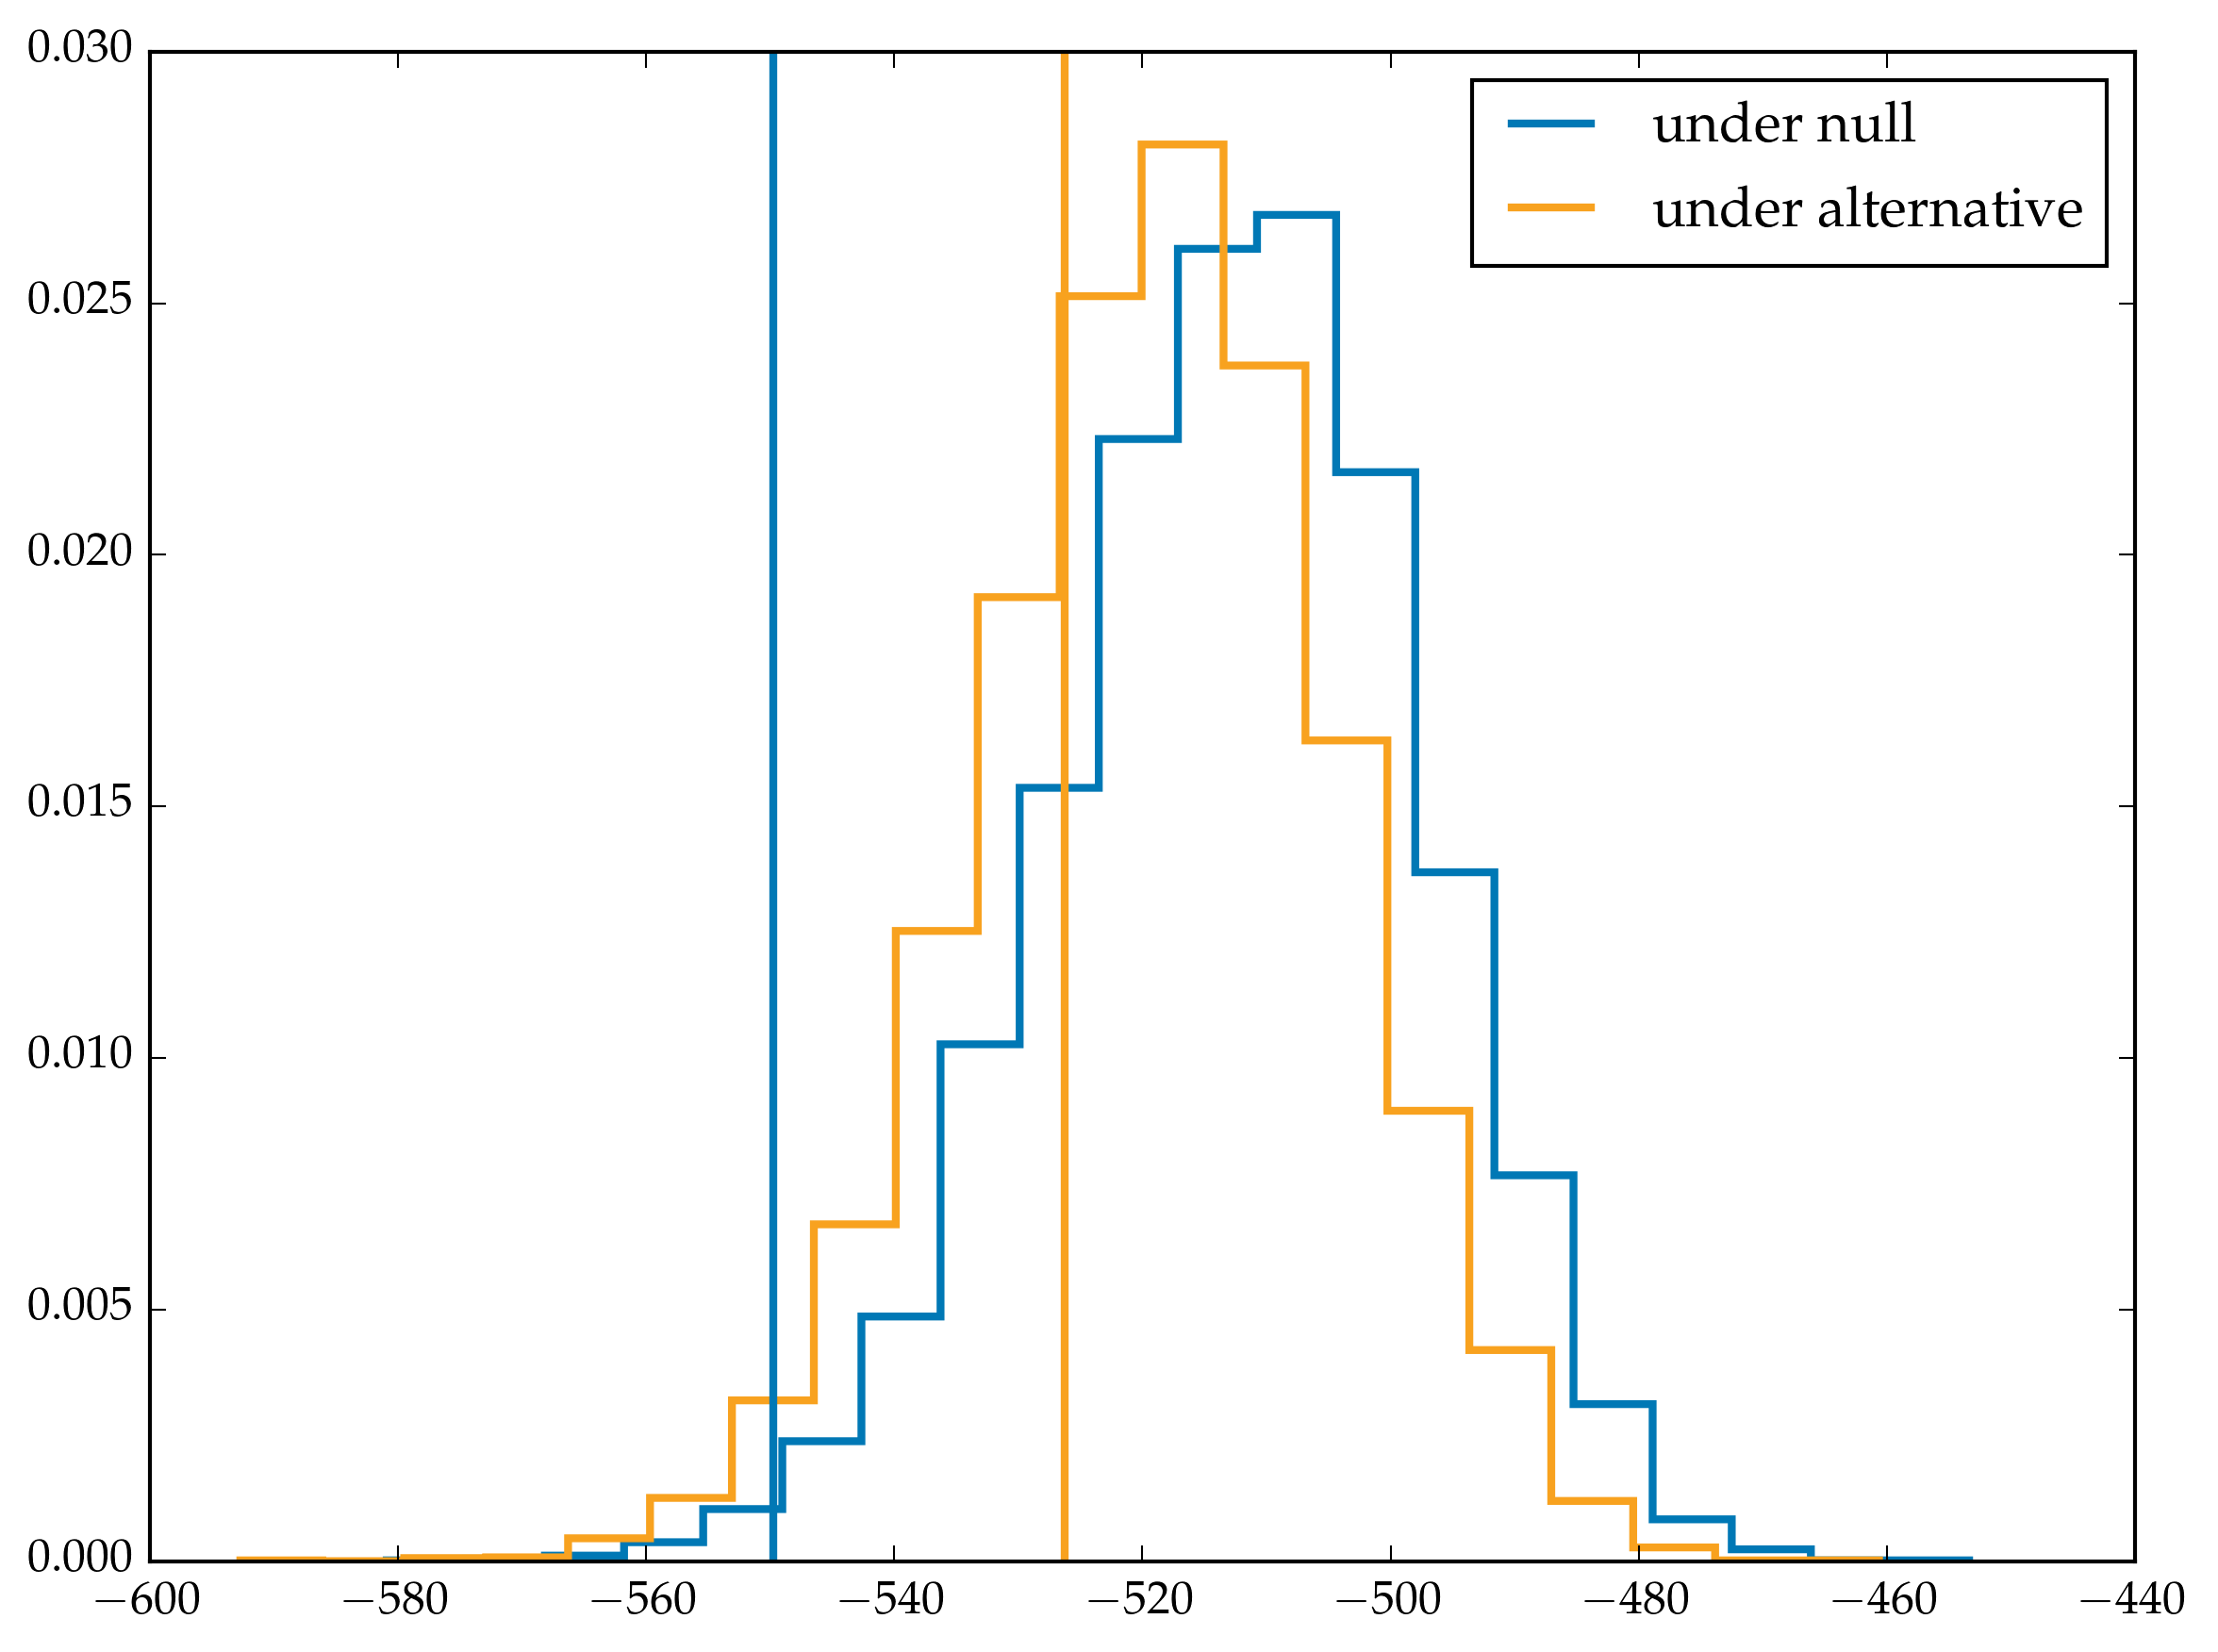

PyObject <matplotlib.legend.Legend object at 0x31aea5090>

In [25]:
plt.plt[:hist](mLL_sim_null, normed=true, bins=20, color="#0078B5", histtype="step", linewidth=2)
plt.plt[:hist](mLL_sim_altv, normed=true, bins=20, color="#F8A21F", histtype="step", linewidth=2)
plt.axvline(mLL_null, color="#0078B5", label="under null", linewidth=2)
plt.axvline(mLL_altv, color="#F8A21F", label="under alternative", linewidth=2)
plt.legend()

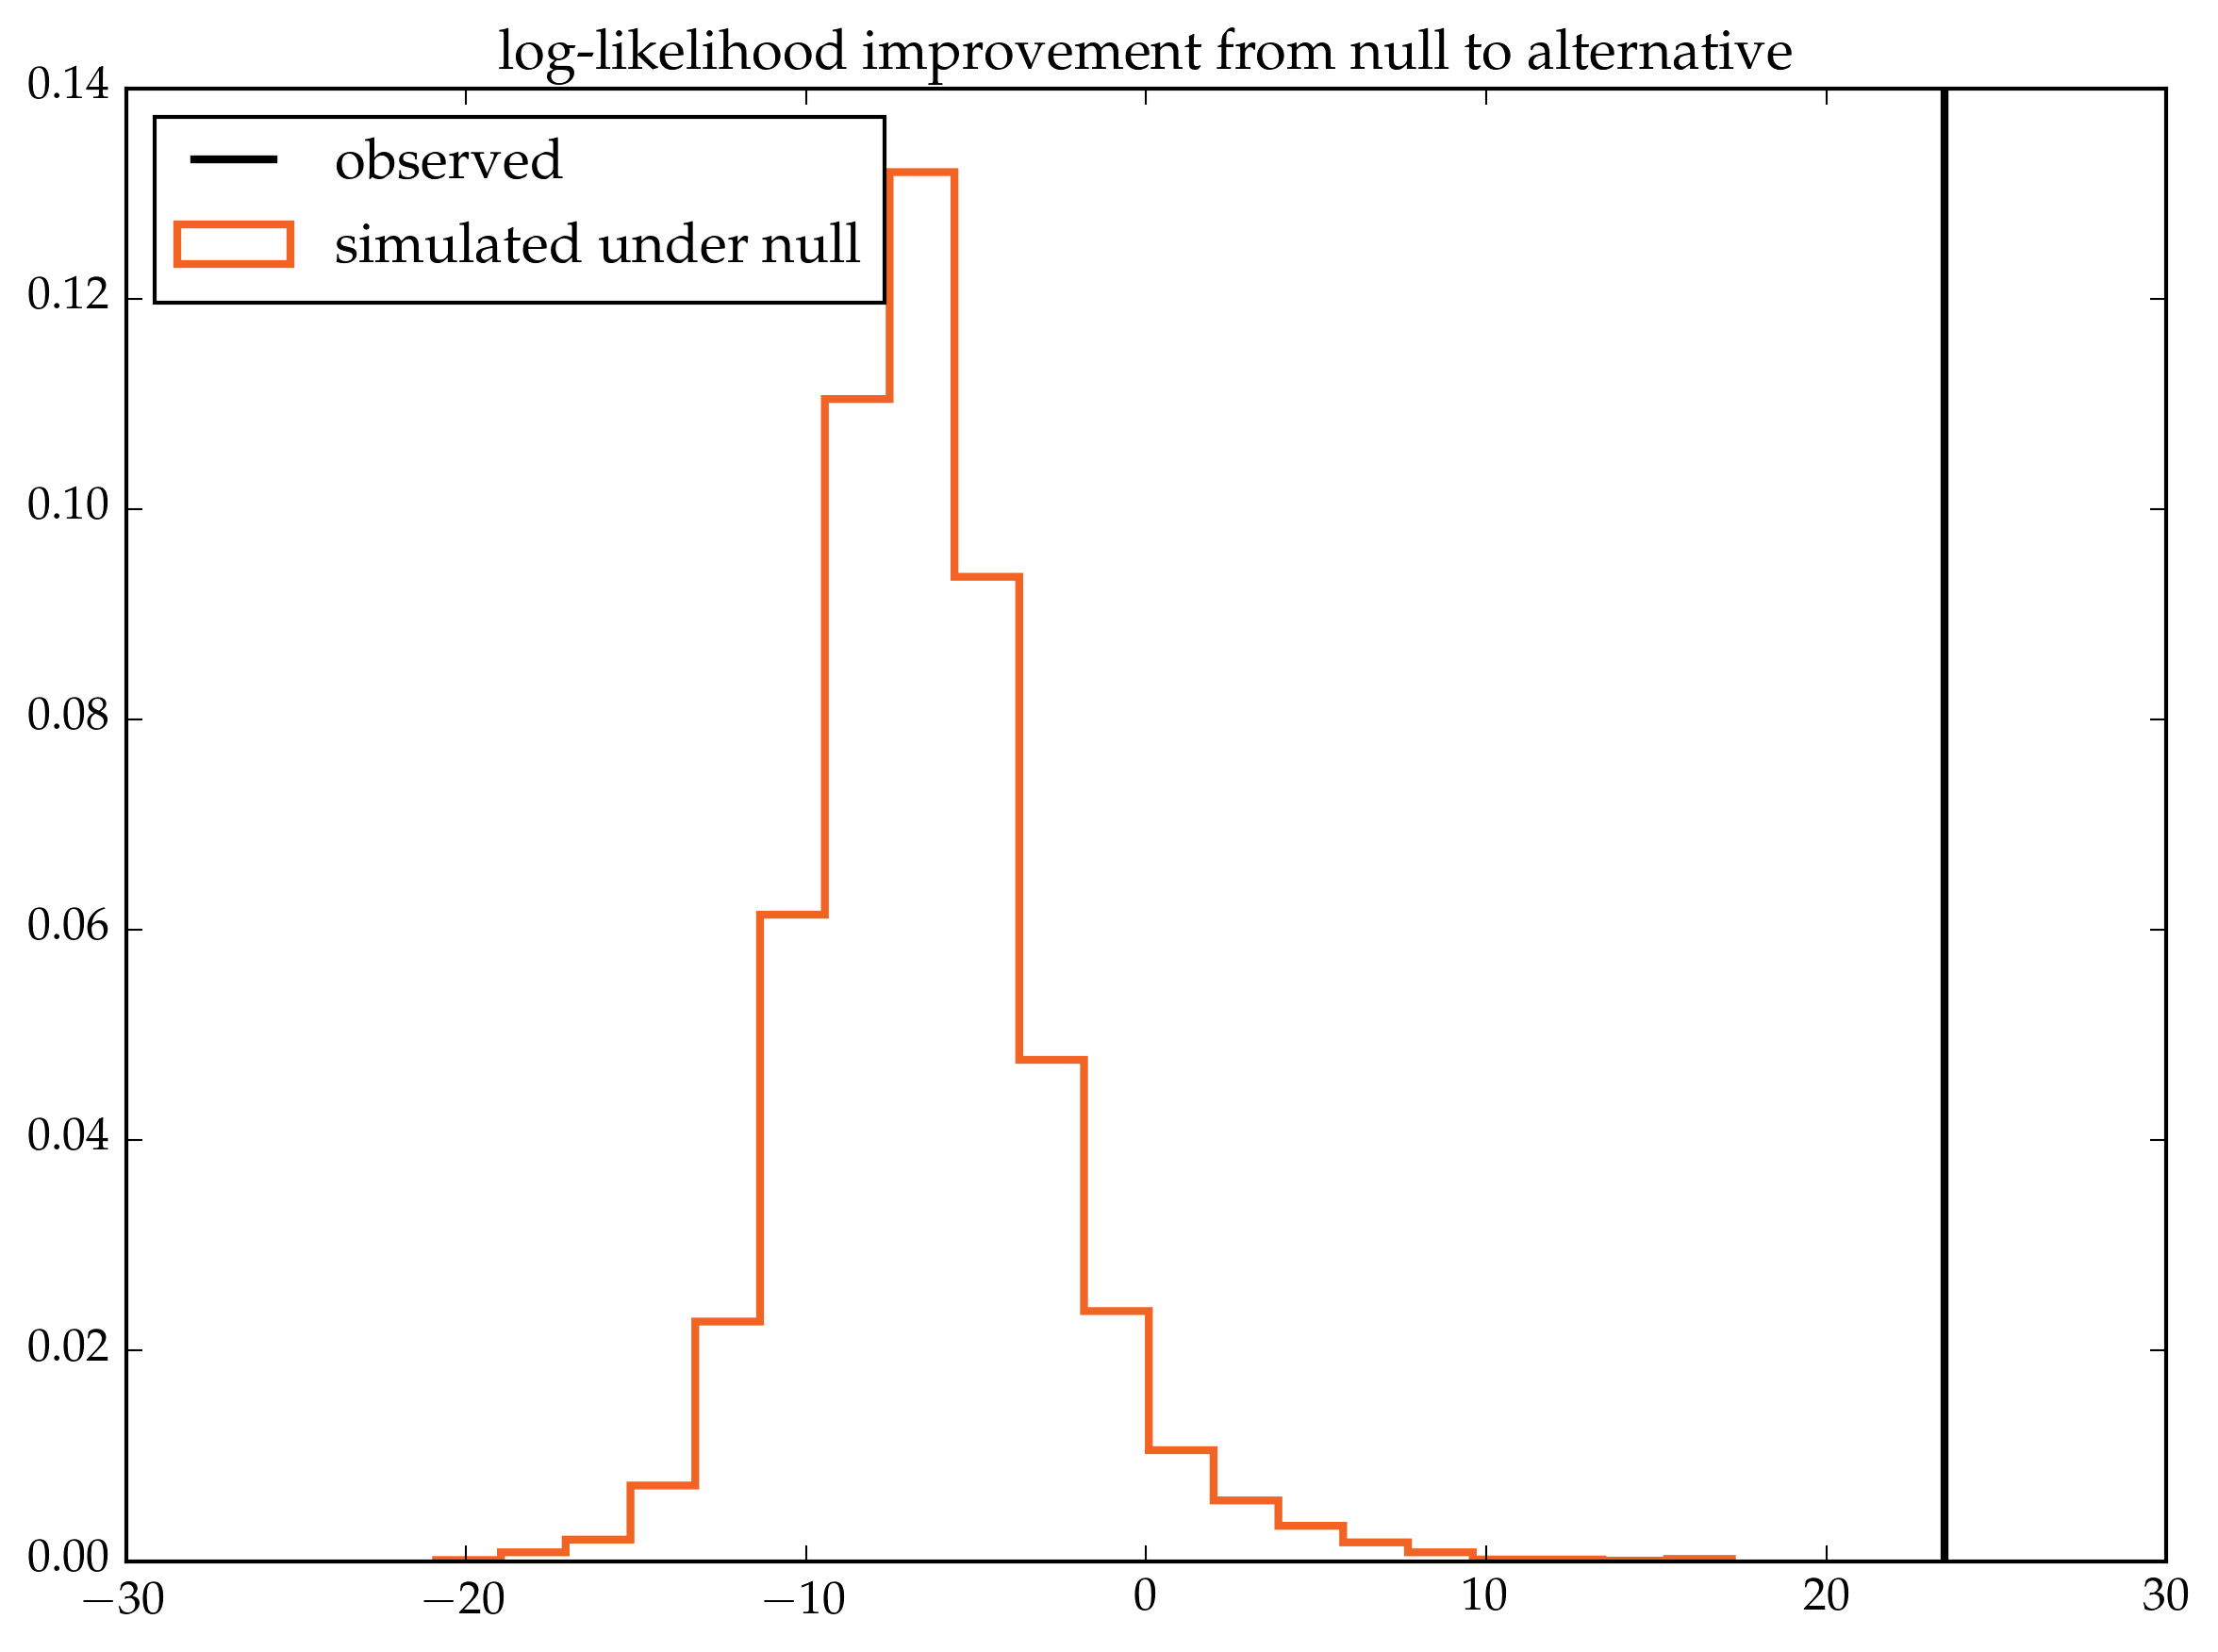

PyObject <matplotlib.text.Text object at 0x31c0dbf10>

In [26]:
plt.plt[:hist](mLL_sim_altv.-mLL_sim_null, normed=true, bins=20, color="#F16424", histtype="step", linewidth=2, label="simulated under null")
plt.axvline(mLL_altv-mLL_null, color="black", label="observed", linewidth=2)
plt.legend(loc="best")
plt.title("log-likelihood improvement from null to alternative")

In [27]:
mean((mLL_sim_altv.-mLL_sim_null) .> (mLL_altv-mLL_null))

0.0

## checking validity of test

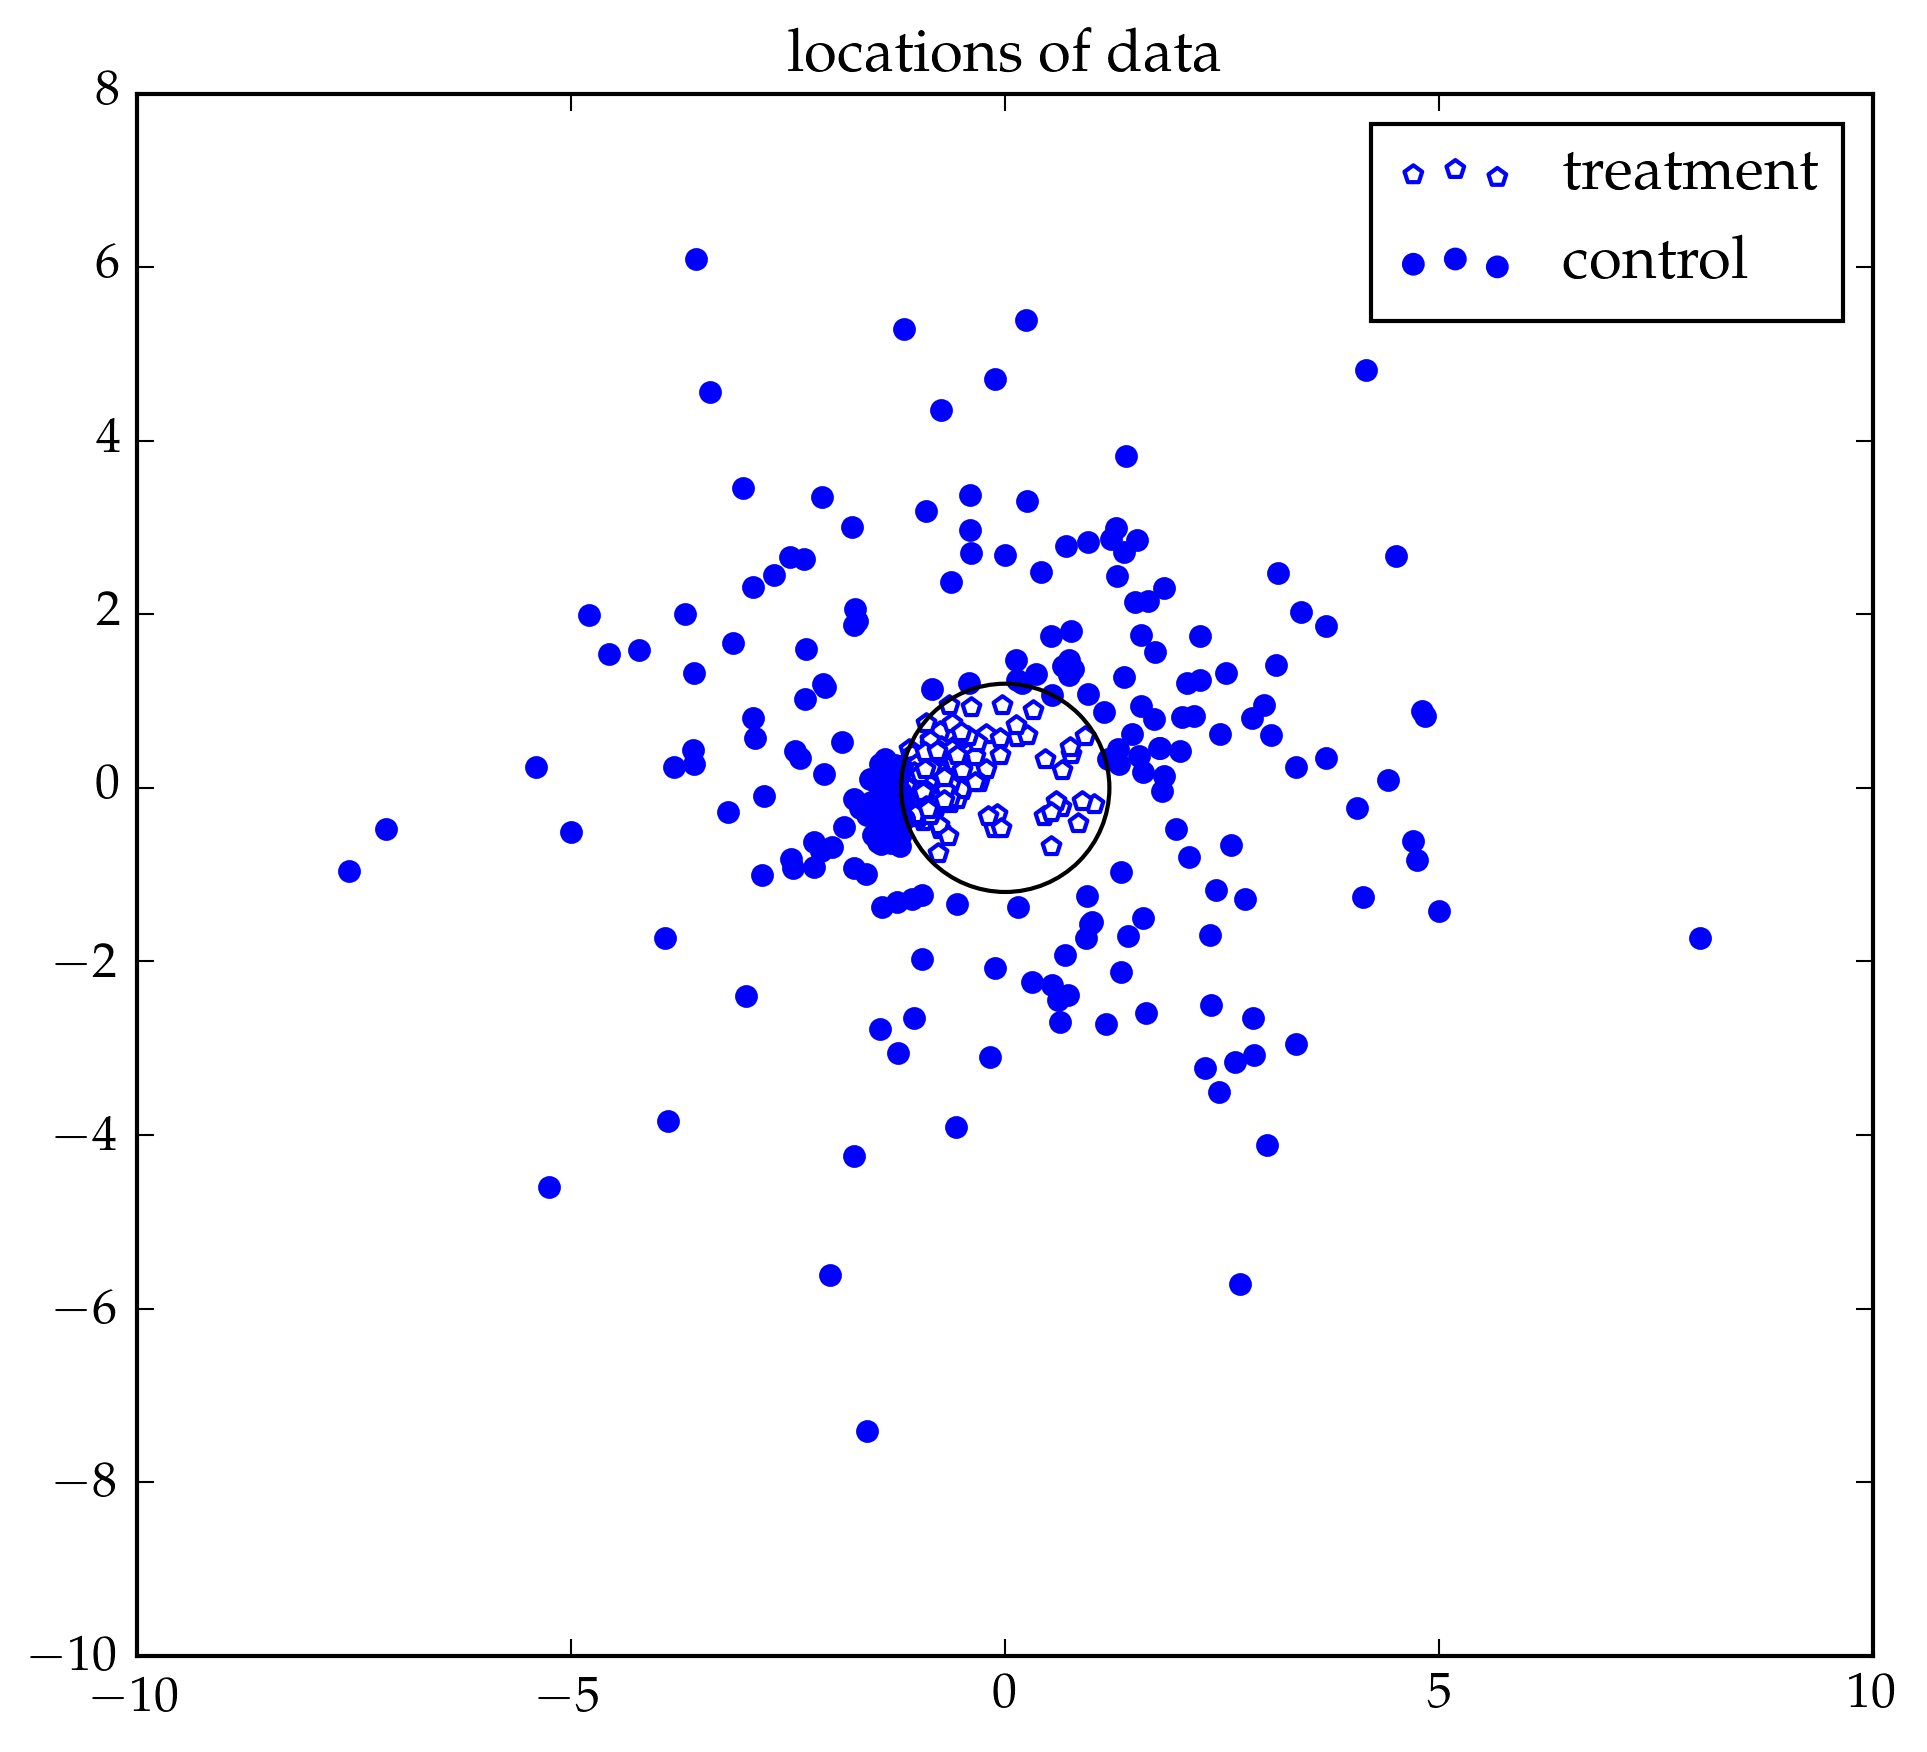

In [28]:
plt.scatter(X[1,inside],X[2,inside], color="white", edgecolor="blue", marker="p", label="treatment")
plt.scatter(X[1,!inside],X[2,!inside], color="blue", label="control")
circle=plt.plt[:Circle]((0,0),r◫,color="black", fill=false)
plt.gca()[:add_artist](circle)
plt.gca()[:set_aspect]("equal")
plt.title("locations of data")
plt.legend(loc="best")
;

In [29]:
GeoRDD.shift_for_even_split(90.0, X)

-0.42878502882708125

In [30]:
function plot_line(angle::Float64, shift::Float64, X::Matrix; kwargs...)
    meanx=mean(X[1,:])
    meany=mean(X[2,:])
    dydx=tand(angle)
    direction=sign(cosd(angle+90))
    if direction==0.0
        direction=1.0
    end
    shift_x = shift*cosd(angle+90)*direction
    shift_y = shift*sind(angle+90)*direction
    
    xlim=plt.xlim()
    ylim=plt.ylim()
    xlim_arr = Float64[xlim[1],xlim[2]]
    ylim_arr = Float64[ylim[1],ylim[2]]
    if dydx > 1e3
        plt.axvline(meanx+shift_x, color="red"; kwargs...)
    elseif dydx > 10
        plt.plot(meanx+(ylim_arr.-meany.-shift_y)./dydx+shift_x,ylim_arr; color="red", kwargs...)
    else
        plt.plot(xlim_arr,meany+(xlim_arr.-shift_x.-meanx).*dydx+shift_y; color="red", kwargs...)
    end
    plt.xlim(xlim)
    plt.ylim(ylim)
end

plot_line (generic function with 1 method)

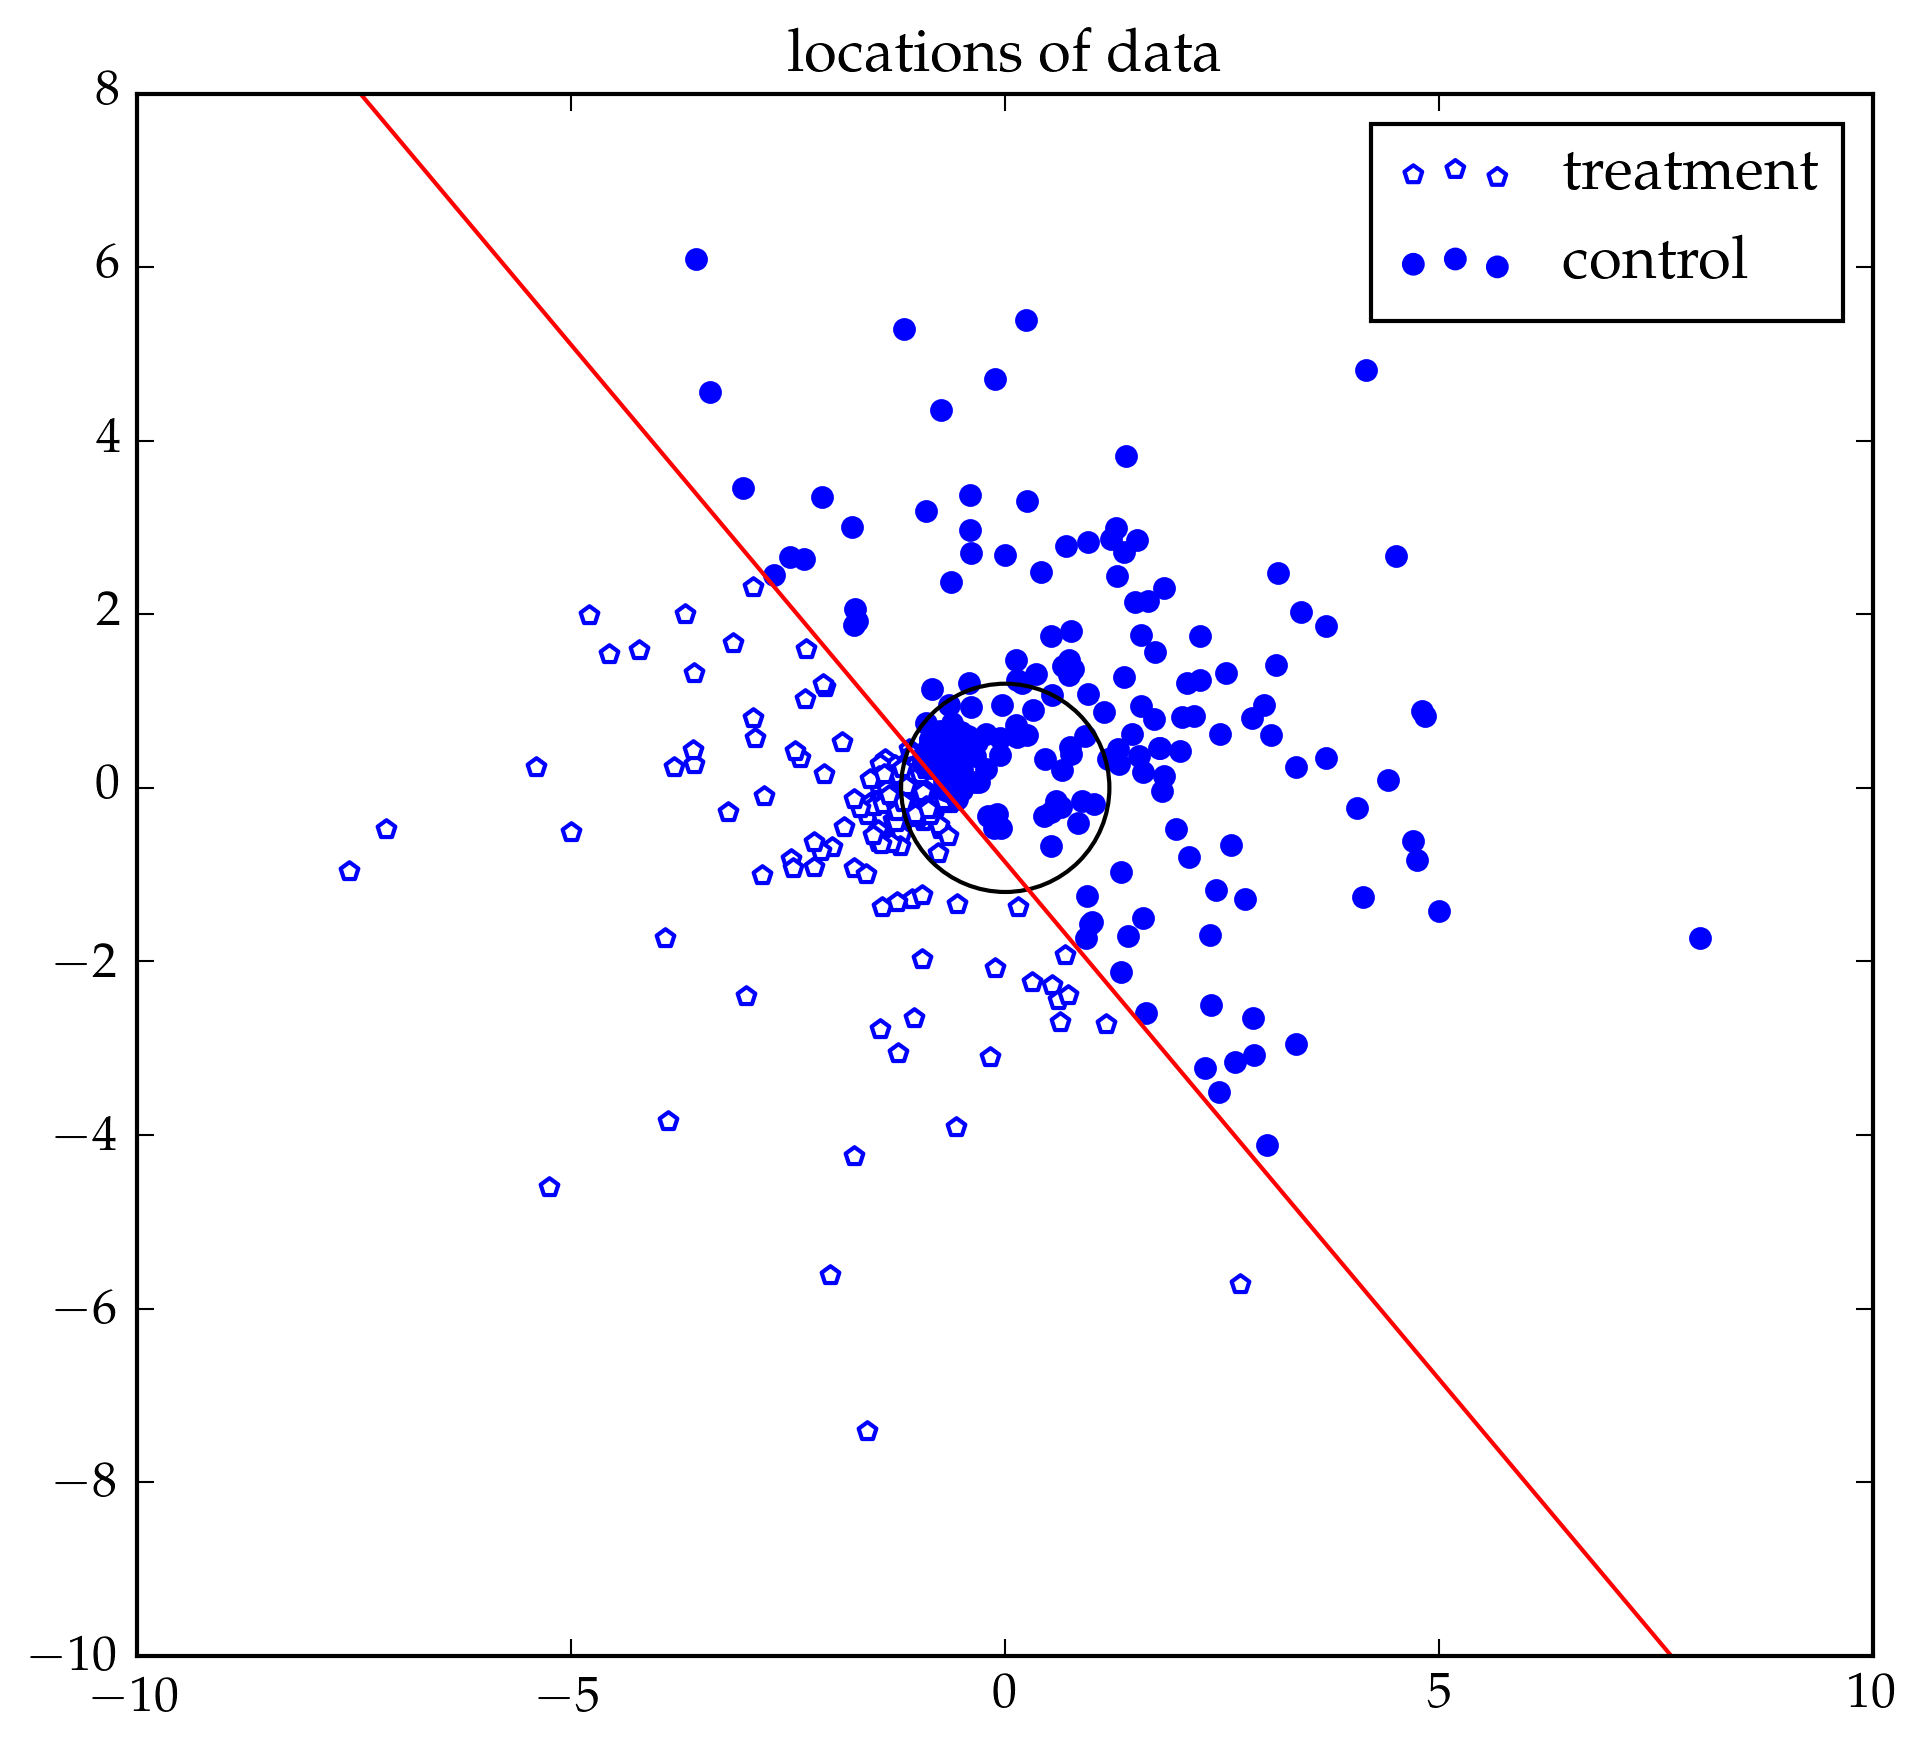

/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [31]:
circle=plt.plt[:Circle]((0,0),r◫,color="black", fill=false)
plt.gca()[:add_artist](circle)
plt.gca()[:set_aspect]("equal")
plt.title("locations of data")
plt.legend(loc="best")

angle = 130.0
shift = GeoRDD.shift_for_even_split(angle, X)
are_left = GeoRDD.left_points(angle, shift, X)

plt.scatter(X[1,are_left],X[2,are_left], color="white", edgecolor="blue", marker="p", label="treatment")
plt.scatter(X[1,!are_left],X[2,!are_left], color="blue", label="control")

plot_line(angle,shift, X)

plt.legend(loc="best")
;

In [36]:
@time GeoRDD.boot_mLLtest(gp_fit_inside, gp_fit_outside, 10000; update_mean=true)

  5.109938 seconds (757.63 k allocations: 431.284 MB, 0.79% gc time)


0.0

In [33]:
GeoRDD.placebo(0.0, X, Y, kern, log(√σy2_star), 1000)

0.11

In [34]:
pvals = [GeoRDD.placebo(float(angle), X, Y, kern, log(√σy2_star), 1000) for angle in 1:180];

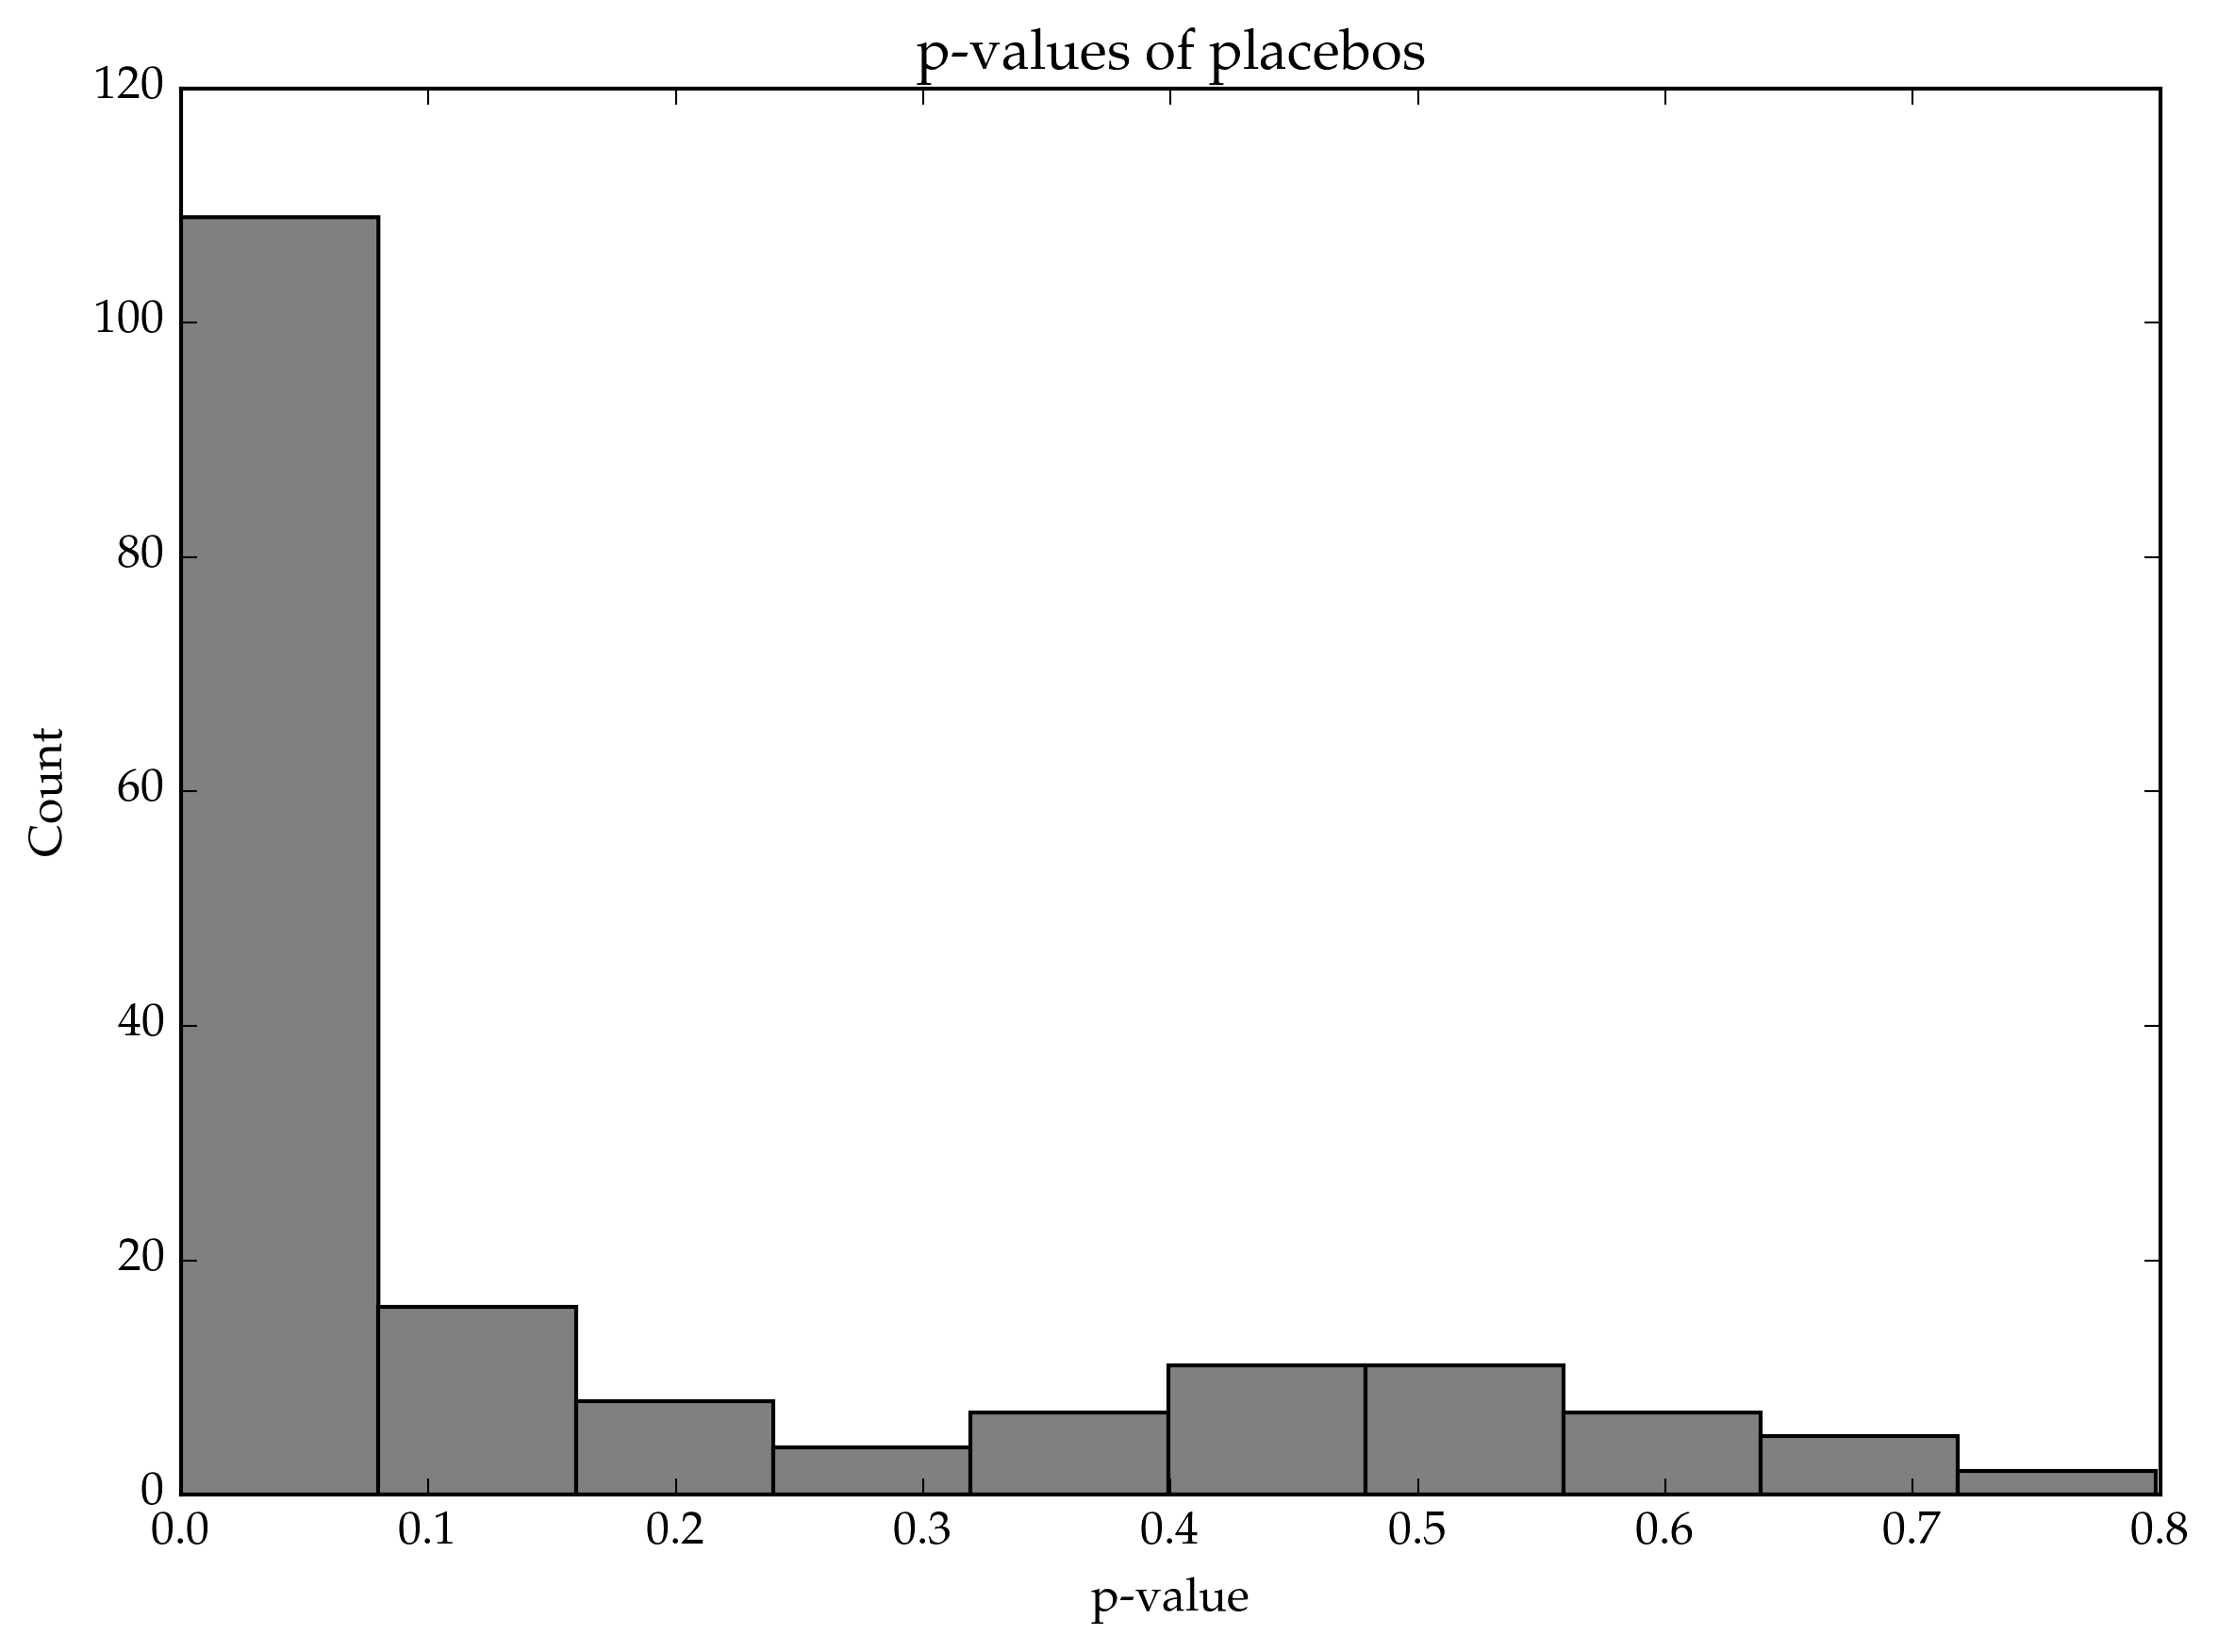

PyObject <matplotlib.text.Text object at 0x324971490>

In [35]:
plt.plt[:hist](pvals, color="grey")
plt.xlabel("p-value")
plt.ylabel("Count")
plt.title("p-values of placebos")

Ideally we'd like this histogram to be uniform.